In [42]:
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [43]:
def import_datasets(secim): # 0 ise 50'lik 1 ise 250'lik 2 ise sigmoid ve relu için 3 ise weights in boyutu 1 arttırılmış 4 ise bge-m3 5 ise multilingual e5 modeli 6 ise MLP 7 ise alakasız cevap  8 ise alakalı uzun cevap
    if secim ==0:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings.npy") #50 train 50 test
        num_questions = 50
    elif secim ==4:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings5.npy") #250 train 50 test
        num_questions = 250 
    elif secim ==5:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings6.npy") #250 train 50 test
        num_questions = 250 
    elif secim ==7:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings2.npy") #250 train 50 test
        num_questions = 50 
    elif secim ==8:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings3.npy") #250 train 50 test
        num_questions = 50 
    else:
        data = np.load(r"C:\Users\fatih\OneDrive\Masaüstü\bölüm\2-1\Differential Equations\ödev\kaggle çıktıları\dataset_embeddings4.npy") #250 train 50 test
        num_questions = 250 
    d = 1024                   # embedding boyutu
    if secim ==3:
        weights = np.zeros((1,2*d+2))
        x_train = np.zeros((2*num_questions, 2*d + 2))
        x_test = np.zeros((2*num_questions, 2*d + 2))
    elif secim == 6:
        x_train = np.zeros((2*num_questions, 2*d + 1))
        x_test = np.zeros((2*num_questions, 2*d + 1))

        W1 = np.random.randn(10, 2049) * 0.1 # Gizli katmandaki nöron sayısı 10 olsun
        W2 = np.random.randn(1, 10) * 0.1
        weights = [W1, W2]
    else:
        weights = np.random.randn(1, 2049) * 0.01  # Küçük rastgele sayılar
        x_train = np.zeros((2*num_questions, 2*d + 1))
        x_test = np.zeros((2*num_questions, 2*d + 1))
    
    y_train = np.zeros((2*num_questions, 1))
    y_test = np.zeros((2*num_questions, 1))
    index = 0

    for i in range(0, num_questions*3, 3):
        soru = data[i]
        iyi  = data[i+1]
        kotu = data[i+2]

        # iyi örnek
        if secim ==3:
            iyi_similarity = np.dot(soru,iyi)
            x_train[index] = np.concatenate([soru, iyi, [1.0],[iyi_similarity]])
        else:
            x_train[index] = np.concatenate([soru, iyi, [1.0]])
        y_train[index] = 1
        
        index += 1

        # kotu örnek
        if secim ==3:
            kotu_similarity = np.dot(soru,kotu)
            x_train[index] = np.concatenate([soru, kotu, [1.0],[kotu_similarity]])
        else:
            x_train[index] = np.concatenate([soru, kotu, [1.0]])
        if secim ==2:
            y_train[index] = 0
        else:
            y_train[index] = -1
        index += 1
    
    index = 0

    for i in range(num_questions*3, num_questions*3 +150, 3):
        soru = data[i]
        iyi  = data[i+1]
        kotu = data[i+2]

        # iyi örnek
        if secim ==3:
            iyi_similarity = np.dot(soru,iyi)
            x_test[index] = np.concatenate([soru, iyi, [1.0],[iyi_similarity]])
        else:
            x_test[index] = np.concatenate([soru, iyi, [1.0]])
        y_test[index] = 1
        index += 1

        # kotu örnek
        if secim ==3:
            kotu_similarity = np.dot(soru,kotu)
            x_test[index] = np.concatenate([soru, kotu, [1.0],[kotu_similarity]])
        else:
            x_test[index] = np.concatenate([soru, kotu, [1.0]])
        if secim ==2:
            y_test[index] = 0
        else:
            y_test[index] = -1
        index += 1
    return weights,x_train,x_test,y_train,y_test


Sonrasında Kullanılacak Olan Aktivasyon fonksiyonları

In [44]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(z):
    return np.maximum(0, z)

def relu_turev(z):
    # z pozitifse türev 1, negatifse 0
    return (z > 0).astype(float)

def bce(weights,x_test,y_test):
    toplam_fark =0.0
    fark = 0.0
    for i in range (100):
        tahmin_y = sigmoid(weights @ x_test[i])
        fark = y_test[i]*np.log(tahmin_y+1e-8)+(1-y_test[i])*np.log(1-tahmin_y+1e-8)
        toplam_fark += fark
    return -toplam_fark/100

def cost(weights,x_train,y_train,secim):
    if secim ==0:
        toplam_fark =0.0
        fark = 0.0
        for i in range (100):
            tahmin_y = np.tanh(weights @ x_train[i])
            fark = (y_train[i]-tahmin_y)**2
            toplam_fark += fark
        return toplam_fark/100
    elif secim ==1:
        return bce(weights,x_train,y_train)
    elif secim ==2:
        toplam_fark =0.0
        fark = 0.0
        for i in range (100):
            tahmin_y = relu(weights @ x_train[i])
            fark = (y_train[i]-tahmin_y)**2
            toplam_fark += fark
        return toplam_fark/100
    if secim == 3:
        W1, W2 = weights[0], weights[1]
        toplam_hata = 0
        for i in range(x_train.shape[0]):
            z1 = W1 @ x_train[i]
            sonuc1 = relu(z1)
            z2 = W2 @ sonuc1
            sonuc2 = np.tanh(z2)
            toplam_hata += (sonuc2 - y_train[i]) ** 2
        return toplam_hata / 100

def accuracy(weights,x_train,y_train,secim):
    dogru =0
    for i in range (100):
        if secim == 0:
            tahmin_y = np.tanh(weights @ x_train[i])
        elif secim == 1:
            tahmin_y = sigmoid(weights @ x_train[i])
        elif secim == 2:
            tahmin_y = relu(weights @ x_train[i])
        elif secim ==3:
            W1 = weights[0]
            W2 = weights[1]

            z1 = W1 @ x_train[i]
            sonuc1 = relu(z1)      # Gizli katman çıkışı
            z2 = W2 @ sonuc1
            tahmin_y = np.tanh(z2)   # Sonuç 
        
        #düzelt
        if secim ==0:
            if tahmin_y <0.0:
                tahmin_y = -1.0
            else:
                tahmin_y = 1.0
        else:
            if tahmin_y <0.5:
                tahmin_y = 0.0
            else:    
                tahmin_y = 1.0
            
        if tahmin_y == y_train[i]:
            dogru+=1
        
    return dogru/100

Optimizasyon teknikleri: Gradient_descent,SGD,Adam,Mini Batched Adam

In [ ]:
def gradient_descent(weights, x_train, y_train, x_test, y_test, secim):
    rate = 0.1
    eski_loss = 1.0
    change = 1.0
    
    train_steps = []
    test_steps = []
    train_acc_steps = []
    test_acc_steps = []
    w_steps = []
    
    N = x_train.shape[0]  # Veri sayısı
    i = 0
    
    while i < 3000 and change > 1e-6:
        
        # 1. ADIM: Gradyan Toplamlarını Sıfırla (Her epoch başında)
        if secim == 3:
            toplam_grad_W1 = np.zeros_like(weights[0])
            toplam_grad_W2 = np.zeros_like(weights[1])
        else:
            toplam_turev = np.zeros_like(weights)
        
        # 2. ADIM: Tüm Veri Setini Gez ve Gradyanları Topla
        for j in range(N):
            if secim == 0: # Tanh
                tahmin_y = np.tanh(weights @ x_train[j])
                turev = (2 * (tahmin_y - y_train[j]) * (1 - tahmin_y**2)) * x_train[j]
                toplam_turev += turev  # Güncelleme yapma, topla!
                
            elif secim == 1: # Sigmoid
                tahmin_y = sigmoid(weights @ x_train[j])
                turev = (tahmin_y - y_train[j]) * x_train[j]
                toplam_turev += turev
                
            elif secim == 2: # Relu
                tahmin_y = relu(weights @ x_train[j])
                d_relu = 2 * (tahmin_y - y_train[j]) * relu_turev(weights @ x_train[j])
                turev = x_train[j] * d_relu
                toplam_turev += turev
                
            elif secim == 3: # MLP (2 Katmanlı)
                W1 = weights[0]
                W2 = weights[1]

                z1 = W1 @ x_train[j]
                sonuc1 = relu(z1)
                z2 = W2 @ sonuc1
                sonuc2 = np.tanh(z2)

                # Backward
                error = sonuc2 - y_train[j]
                d_output = 2 * error * (1 - sonuc2**2)
                
                grad_W2 = d_output * sonuc1
                d_hidden = (W2.flatten() * d_output) * relu_turev(z1)
                grad_W1 = np.outer(d_hidden, x_train[j])
                

                toplam_grad_W1 += grad_W1
                toplam_grad_W2 += grad_W2


        if secim == 3:
            weights[0] = weights[0] - rate * (toplam_grad_W1 / N)
            weights[1] = weights[1] - rate * (toplam_grad_W2 / N)
        else:
            weights = weights - rate * (toplam_turev / N)
            
        # --- Kayıt İşlemleri ---
        loss = cost(weights, x_train, y_train, secim)
        train_steps.append(loss)
        
        val_loss = cost(weights, x_test, y_test, secim)
        test_steps.append(val_loss)

        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        
        if secim == 3:
            w_combined = np.concatenate((weights[0].flatten(), weights[1].flatten()))
            w_steps.append(w_combined)
        else:
            w_steps.append(weights.copy().flatten())
            
        change = np.fabs(loss - eski_loss)
        eski_loss = loss
        i += 1
        
    return weights, train_steps, test_steps, train_acc_steps, test_acc_steps, w_steps

In [46]:
def stochastic_gradient_descent(weights,x_train,y_train,x_test,y_test,secim):
    rate =0.1
    change =1.0
    eski_loss =1.0
    train_steps = []
    test_steps = []

    train_acc_steps = []
    test_acc_steps = []
    w_steps = []
    i=0
    while i<3000 and change > 1e-6:
        j = random.randint(0,x_train.shape[0]-1)
        if secim == 0:
            tahmin_y = np.tanh(weights @ x_train[j])
            turev = (2*(tahmin_y-y_train[j])*(1- tahmin_y*tahmin_y)) * x_train[j]
        elif secim ==1 :
            tahmin_y = sigmoid(weights @ x_train[j])
            turev = (tahmin_y-y_train[j])*x_train[j]
        elif secim == 2:
            tahmin_y = (relu(weights @ x_train[j]))
            d_relu = 2*(tahmin_y-y_train[j]) * relu_turev(weights@x_train[j])
            turev = x_train[j]*d_relu
            
        weights = weights - rate * turev
        
        loss = cost(weights,x_train,y_train,secim)
        train_steps.append(loss)

        val_loss = cost(weights,x_test,y_test,secim)
        test_steps.append(val_loss)
        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        w_steps.append(weights.copy().flatten())
        #print(fark)
        change = np.fabs(loss - eski_loss)
        eski_loss = loss
        i+=1
    return weights,train_steps,test_steps,train_acc_steps, test_acc_steps,w_steps

In [47]:
def adam(weights,x_train,y_train,x_test,y_test,secim):
    rate =0.01
    eski_loss =1.0
    change =1.0
    b1 = 0.9
    b2 =0.999
    train_steps =[]
    test_steps = []
    train_acc_steps = []
    test_acc_steps = []

    w_steps =[]

    m_t = np.zeros_like(weights)
    v_t = np.zeros_like(weights)
    i=0
    while i<3000 and change > 1e-6:
        t = i + 1
        j = random.randint(0,x_train.shape[0]-1)
        if secim == 0:
            tahmin_y = np.tanh(weights @ x_train[j])
            turev = (2*(tahmin_y-y_train[j])*(1- tahmin_y*tahmin_y)) * x_train[j]
        elif secim ==1 :
            tahmin_y = sigmoid(weights @ x_train[j])
            turev = (tahmin_y-y_train[j])*x_train[j]
        elif secim == 2:
            tahmin_y = (relu(weights @ x_train[j]))
            d_relu = 2*(tahmin_y-y_train[j]) * relu_turev(weights@x_train[j])
            turev = x_train[j]*d_relu
            

        m_t = b1 * m_t+ (1-b1) * turev
        v_t = b2 * v_t + (1-b2) * (turev ** 2)

        m_hat = m_t / (1 - b1**t)
        v_hat = v_t / (1 - b2**t)
    
        weights = weights - rate * m_hat / (np.sqrt(v_hat) + 1e-8)
        loss = cost(weights,x_train,y_train,secim)
        train_steps.append(loss)

        val_loss = cost(weights,x_test,y_test,secim)
        test_steps.append(val_loss)
        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        w_steps.append(weights.copy().flatten())
        #print(fark)
        change = np.fabs(loss - eski_loss)
        eski_loss = loss
        i+=1
    return weights,train_steps,test_steps,train_acc_steps, test_acc_steps,w_steps

In [48]:
def batched_adam(weights,x_train,y_train,x_test,y_test,secim):
    rate =0.01
    eski_loss =1.0
    train_steps = []
    test_steps =[]
    w_steps = []
    train_acc_steps = []
    test_acc_steps = []
    change =1.0
    b1 = 0.9
    b2 =0.999
    m_t = np.zeros_like(weights)
    v_t = np.zeros_like(weights)
    i=0
    while i<3000 and change > 1e-6:
        t = i + 1
        toplam_turev = np.zeros_like(weights)
        for j in range(10):
            rand = random.randint(0,x_train.shape[0]-1)
            if secim == 0:
                tahmin_y = np.tanh(weights @ x_train[rand])
                anlik_turev = (2*(tahmin_y-y_train[rand])*(1- tahmin_y*tahmin_y)) * x_train[rand]
            elif secim ==1 :
                tahmin_y = sigmoid(weights @ x_train[rand])
                anlik_turev = (tahmin_y-y_train[rand])*x_train[rand]
            elif secim == 2:
                tahmin_y = (relu(weights @ x_train[rand]))
                d_relu = 2*(tahmin_y-y_train[rand]) * relu_turev(weights@x_train[rand])
                anlik_turev = x_train[rand]*d_relu
                
            toplam_turev +=anlik_turev

        turev = toplam_turev / 10
        m_t = b1 * m_t+ (1-b1) * turev
        v_t = b2 * v_t + (1-b2) * (turev ** 2)

        m_hat = m_t / (1 - b1**t)
        v_hat = v_t / (1 - b2**t)
    
        weights = weights - rate * m_hat / (np.sqrt(v_hat) + 1e-8)
        loss = cost(weights,x_train,y_train,secim)
        train_steps.append(loss)

        val_loss = cost(weights,x_test,y_test,secim)
        test_steps.append(val_loss)
        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        w_steps.append(weights.copy().flatten())
        #print(fark)
        change = np.fabs(loss - eski_loss)
        eski_loss = loss
        i+=1
    return weights,train_steps,test_steps,train_acc_steps, test_acc_steps,w_steps

In [49]:
def adagrad(weights, x_train, y_train,x_test,y_test,secim):
    rate = 0.01
    G = np.zeros_like(weights)

    eski_loss = 1.0
    change = 1.0
    train_steps = []
    test_steps =[]
    train_acc_steps = []
    test_acc_steps = []
    w_steps = []
    i = 0

    while i < 3000 and change > 1e-6:
        for j in range(x_train.shape[0]):
            
            if secim == 0:  # tanh model
                tahmin_y = np.tanh(weights @ x_train[j])
                turev = (2*(tahmin_y - y_train[j]) * (1 - tahmin_y * tahmin_y)) * x_train[j]

            elif secim == 1:  # sigmoid model
                tahmin_y = sigmoid(weights @ x_train[j])
                turev = (tahmin_y - y_train[j]) * x_train[j]

            elif secim == 2:  # relu model
                tahmin_y = relu(weights @ x_train[j])
                d_relu = 2*(tahmin_y - y_train[j]) * relu_turev(weights @ x_train[j])
                turev = x_train[j] * d_relu

            G += turev * turev                
            adjusted_lr = rate / (np.sqrt(G) + 1e-8)
            weights = weights - adjusted_lr * turev

        loss = cost(weights, x_train, y_train, secim)
        train_steps.append(loss)

        val_loss = cost(weights,x_test,y_test,secim)
        test_steps.append(val_loss)
        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        w_steps.append(weights.copy().flatten())

        change = np.abs(loss - eski_loss)
        eski_loss = loss
        i += 1

    return weights, train_steps, test_steps,train_acc_steps, test_acc_steps,w_steps


In [50]:
def rmsprop(weights, x_train, y_train,x_test,y_test,secim):
    rate = 0.01
    beta = 0.9
    G = np.zeros_like(weights)     # RMSProp hareketli ortalama

    eski_loss = 1.0
    change = 1.0
    train_steps = []
    test_steps =[]
    w_steps = []
    train_acc_steps = []
    test_acc_steps = []
    i = 0

    while i < 3000 and change > 1e-6:
        for j in range(x_train.shape[0]):

            if secim == 0:  # tanh
                y_hat = np.tanh(weights @ x_train[j])
                grad = (2*(y_hat - y_train[j])*(1 - y_hat*y_hat)) * x_train[j]

            elif secim == 1:  # sigmoid
                y_hat = sigmoid(weights @ x_train[j])
                grad = (y_hat - y_train[j]) * x_train[j]

            elif secim == 2:  # relu
                y_hat = relu(weights @ x_train[j])
                d_relu = 2*(y_hat - y_train[j]) * relu_turev(weights @ x_train[j])
                grad = x_train[j] * d_relu

            G = beta * G + (1 - beta) * (grad * grad)
            weights = weights - rate * grad / (np.sqrt(G) + 1e-8)

        loss = cost(weights, x_train, y_train, secim)
        train_steps.append(loss)
        val_loss = cost(weights,x_test,y_test,secim)
        test_steps.append(val_loss)
        tr_acc = accuracy(weights, x_train, y_train, secim)
        te_acc = accuracy(weights, x_test, y_test, secim)
        train_acc_steps.append(tr_acc)
        test_acc_steps.append(te_acc)
        w_steps.append(weights.copy().flatten())
        
        change = abs(loss - eski_loss)
        eski_loss = loss
        i += 1

    return weights, train_steps, test_steps,train_acc_steps, test_acc_steps,w_steps


In [51]:
weights,x_train,x_test,y_train,y_test = import_datasets(0)

gd_weights,_,_,_,_,_ = gradient_descent(weights,x_train,y_train,x_test,y_test,0)
sgd_weights,_,_ ,_,_,_=stochastic_gradient_descent(weights,x_train,y_train,x_test,y_test,0)
adam_weights,_,_,_,_,_ =adam(weights,x_train,y_train,x_test,y_test,0)
batched_adam_weights,_,_,_,_,_ = batched_adam(weights,x_train,y_train,x_test,y_test,0)
adagrad_weights,_,_,_,_,_ = adagrad(weights,x_train,y_train,x_test,y_test,0)
rmsprop_weights,_,_,_,_,_ = rmsprop(weights,x_train,y_train,x_test,y_test,0)


print("w=0 icin loss değerleri")
print(f"Gradient Descent MSE: {cost(gd_weights,x_test,y_test,0)}")
print(f"Stochastic  Gradient Descent MSE: {cost(sgd_weights,x_test,y_test,0)}")
print(f"ADAM: {cost(adam_weights,x_test,y_test,0)}")
print(f"Mini-Batched ADAM: {cost(batched_adam_weights,x_test,y_test,0)}")
print(f"AdaGrad: {cost(adagrad_weights,x_test,y_test,0)}")
print(f"RMSPROP: {cost(rmsprop_weights,x_test,y_test,0)}")

w=0 icin loss değerleri
Gradient Descent MSE: [0.2082499]
Stochastic  Gradient Descent MSE: [0.22003928]
ADAM: [0.2879725]
Mini-Batched ADAM: [0.1882099]
AdaGrad: [0.19275884]
RMSPROP: [0.13964562]


In [ ]:

def five_result(secim):  
    methods = ["GD", "SGD", "Adam", "MiniBatch-Adam","AdaGrad","RMSPROP"]
    train_results = {m: [] for m in methods}
    test_results  = {m: [] for m in methods}
    times = {m: [] for m in methods}
    steps = {m: [] for m in methods}
    for i in range(5):
# Örnek Düzeltme
            
            print(f"\nRastgele küçük weightler ile deneme: {i+1}\n")
            # --- GD ---
            start = time.time()
            gd_weights, gd_steps,gd_test_steps,_,_,_ = gradient_descent(weights, x_train, y_train,x_test,y_test,secim)
            t = time.time() - start
            train_results["GD"].append(cost(gd_weights, x_train, y_train,secim))
            test_results["GD"].append(cost(gd_weights, x_test, y_test,secim))
            times["GD"].append(t)
            steps["GD"].append(len(gd_steps))

            # --- SGD ---
            start = time.time()
            sgd_weights, sgd_steps,sgd_test_steps,_,_,_ = stochastic_gradient_descent(weights,x_train,y_train,x_test,y_test,0)
            t = time.time() - start
            train_results["SGD"].append(cost(sgd_weights, x_train, y_train,secim))
            test_results["SGD"].append(cost(sgd_weights, x_test, y_test,secim))
            times["SGD"].append(t)
            steps["SGD"].append(len(sgd_steps))

            # --- ADAM ---
            start = time.time()
            adam_weights, adam_steps,adam_test_steps,_,_,_ = adam(weights,x_train,y_train,x_test,y_test,0)
            t = time.time() - start
            train_results["Adam"].append(cost(adam_weights, x_train, y_train,secim))
            test_results["Adam"].append(cost(adam_weights, x_test, y_test,secim))
            times["Adam"].append(t)
            steps["Adam"].append(len(adam_steps))

            # --- Mini-Batched ADAM ---
            start = time.time()
            batched_adam_weights, batched_adam_steps,batched_adam_test_steps,_,_,_ = batched_adam(weights,x_train,y_train,x_test,y_test,0)
            t = time.time() - start
            train_results["MiniBatch-Adam"].append(cost(batched_adam_weights, x_train, y_train,secim))
            test_results["MiniBatch-Adam"].append(cost(batched_adam_weights, x_test, y_test,secim))
            times["MiniBatch-Adam"].append(t)
            steps["MiniBatch-Adam"].append(len(batched_adam_steps))
            
            #adagrad
            start = time.time()
            adagrad_weights, adagrad_steps,adagrad_test_steps,_,_,_ = adagrad(weights,x_train,y_train,x_test,y_test,0)
            t = time.time() - start
            train_results["AdaGrad"].append(cost(adagrad_weights, x_train, y_train,secim))
            test_results["AdaGrad"].append(cost(adagrad_weights, x_test, y_test,secim))
            times["AdaGrad"].append(t)
            steps["AdaGrad"].append(len(adagrad_steps))

            #rmsprop
            start = time.time()
            rmsprop_weights, rmsprop_steps,rmsprop_test_steps,_,_,_ = rmsprop(weights,x_train,y_train,x_test,y_test,0)
            t = time.time() - start
            train_results["RMSPROP"].append(cost(rmsprop_weights, x_train, y_train,secim))
            test_results["RMSPROP"].append(cost(rmsprop_weights, x_test, y_test,secim))
            times["RMSPROP"].append(t)
            steps["RMSPROP"].append(len(rmsprop_steps))

            # Terminal çıktı
            print(f"GD Test MSE: {test_results['GD'][-1]}, Accuracy: {accuracy(gd_weights,x_test,y_test,secim)}")
            print(f"SGD Test MSE: {test_results['SGD'][-1]}, Accuracy: {accuracy(gd_weights,x_test,y_test,secim)}")
            print(f"Adam Test MSE: {test_results['Adam'][-1]}, Accuracy: {accuracy(gd_weights,x_test,y_test,secim)}")
            print(f"Mini-Batch Adam Test MSE: {test_results['MiniBatch-Adam'][-1]}, Accuracy: {accuracy(gd_weights,x_test,y_test,secim)}")
            print(f"AdaGradTest MSE: {test_results['AdaGrad'][-1]}, Accuracy: {accuracy(adagrad_weights,x_test,y_test,secim)}")
            print(f"RMSPROP Test MSE: {test_results['RMSPROP'][-1]}, Accuracy: {accuracy(rmsprop_weights,x_test,y_test,secim)}")

    return methods,times,steps,train_results,test_results

In [53]:
methods,times,steps,train_results,test_results = five_result(0)


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.2082499], Accuracy: 0.95
SGD Test MSE: [0.18938519], Accuracy: 0.95
Adam Test MSE: [0.20206928], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.19538981], Accuracy: 0.95
AdaGradTest MSE: [0.19275884], Accuracy: 0.95
RMSPROP Test MSE: [0.13964562], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.2082499], Accuracy: 0.95
SGD Test MSE: [0.20610949], Accuracy: 0.95
Adam Test MSE: [0.1890452], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.2073688], Accuracy: 0.95
AdaGradTest MSE: [0.19275884], Accuracy: 0.95
RMSPROP Test MSE: [0.13964562], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.2082499], Accuracy: 0.95
SGD Test MSE: [0.22869552], Accuracy: 0.95
Adam Test MSE: [0.19035637], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.23700456], Accuracy: 0.95
AdaGradTest MSE: [0.19275884], Accuracy: 0.95
RMSPROP Test MSE: [0.13964562], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 4

GD Test MS

Yanlış cevaplar alakalı.

In [54]:
weights,x_train,x_test,y_train,y_test = import_datasets(7)
methods,times,steps,train_results,test_results = five_result(0)



Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.6059446], Accuracy: 0.82
SGD Test MSE: [0.59944558], Accuracy: 0.82
Adam Test MSE: [0.64232662], Accuracy: 0.82
Mini-Batch Adam Test MSE: [0.56479992], Accuracy: 0.82
AdaGradTest MSE: [0.59316374], Accuracy: 0.82
RMSPROP Test MSE: [0.61877681], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.6059446], Accuracy: 0.82
SGD Test MSE: [0.59852602], Accuracy: 0.82
Adam Test MSE: [0.62705052], Accuracy: 0.82
Mini-Batch Adam Test MSE: [0.64394157], Accuracy: 0.82
AdaGradTest MSE: [0.59316374], Accuracy: 0.82
RMSPROP Test MSE: [0.61877681], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.6059446], Accuracy: 0.82
SGD Test MSE: [0.5858003], Accuracy: 0.82
Adam Test MSE: [0.62810453], Accuracy: 0.82
Mini-Batch Adam Test MSE: [0.57141066], Accuracy: 0.82
AdaGradTest MSE: [0.59316374], Accuracy: 0.82
RMSPROP Test MSE: [0.61877681], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 4

GD Test M

Yanlış cevaplar alakasız. Ayrıca doğru ve yanlış cevaplar uzun.

In [55]:
weights,x_train,x_test,y_train,y_test = import_datasets(8)
methods,times,steps,train_results,test_results = five_result(0)


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.14724896], Accuracy: 0.97
SGD Test MSE: [0.20880479], Accuracy: 0.97
Adam Test MSE: [0.15666056], Accuracy: 0.97
Mini-Batch Adam Test MSE: [0.1257548], Accuracy: 0.97
AdaGradTest MSE: [0.1305269], Accuracy: 0.96
RMSPROP Test MSE: [0.1375242], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.14724896], Accuracy: 0.97
SGD Test MSE: [0.24734127], Accuracy: 0.97
Adam Test MSE: [0.15623445], Accuracy: 0.97
Mini-Batch Adam Test MSE: [0.13279558], Accuracy: 0.97
AdaGradTest MSE: [0.1305269], Accuracy: 0.96
RMSPROP Test MSE: [0.1375242], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.14724896], Accuracy: 0.97
SGD Test MSE: [0.18529308], Accuracy: 0.97
Adam Test MSE: [0.18868994], Accuracy: 0.97
Mini-Batch Adam Test MSE: [0.13644739], Accuracy: 0.97
AdaGradTest MSE: [0.1305269], Accuracy: 0.96
RMSPROP Test MSE: [0.1375242], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 4

GD Test MSE:

In [56]:
def graphics(methods,times,steps,train_results,test_results,secim):
    # 1. Veri Setini Yükle
    weights_dummy, x_train, x_test, y_train, y_test = import_datasets(secim)
    d_dim = weights_dummy.shape[1]
    
    # 2. Adil karşılaştırma için tüm algoritmalar AYNI rastgele ağırlıkla başlamalı
    # Simetriyi kırmak için çok küçük rastgele sayılar kullanıyoruz
    initial_weights = np.random.randn(1, d_dim) * 0.05
    
    # Sonuçları saklayacağımız sözlük
    results = {}
    
    # Karşılaştırılacak Algoritmalar Listesi
    # (Fonksiyon Adı, Etiket Adı)
    algorithms = [
        (gradient_descent, "Gradient Descent"),
        (stochastic_gradient_descent, "SGD"),
        (adam, "Adam"),
        (batched_adam, "Mini-Batch Adam"),
        (adagrad, "AdaGrad"),
        (rmsprop, "RMSProp")
    ]

    print("Algoritmalar çalıştırılıyor ve veriler toplanıyor...")
    
    for func, name in algorithms:
        print(f"{name} koşuluyor...")
        
        # Süre ölçümü (Time vs Loss grafiği için)
        start_time = time.time()
        
        # Fonksiyonu çağır (Sizin güncellediğiniz yapı: w, train_hist, test_hist)
        # w_init.copy() kullanıyoruz ki bir önceki eğitim ağırlığı değiştirmesin
        _, train_hist, test_hist,train_acc,test_acc,_ = func(initial_weights.copy(), x_train, y_train, x_test, y_test, secim)
        
        end_time = time.time()
        total_time = end_time - start_time
        
        # Time eksenini oluştur (Toplam süreyi adım sayısına bölerek yaklaşıklık yapıyoruz)
        # Çünkü döngü içinde süre ölçümü yaparsak eğitim çok yavaşlar.
        time_axis = np.linspace(0, total_time, len(train_hist))
        
        results[name] = {
            'train': train_hist,
            'test': test_hist,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'time': time_axis
        }

    # --- 3. GRAFİK ÇİZİMİ ---
    print("Grafikler çiziliyor...")
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Renk paleti
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    # A) Epoch vs Train Loss
    for i, (name, data) in enumerate(results.items()):
        axs[0, 0].plot(data['train'], label=name, color=colors[i], linewidth=1.5)
    axs[0, 0].set_title('Epoch vs Train Loss (Eğitim Hatası)')
    axs[0, 0].set_xlabel('İterasyon (Epoch/Step)')
    axs[0, 0].set_ylabel('Loss (Hata)')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # B) Epoch vs Test Loss
    for i, (name, data) in enumerate(results.items()):
        axs[0, 1].plot(data['test'], label=name, color=colors[i], linewidth=1.5)
    axs[0, 1].set_title('Epoch vs Test Loss (Genelleştirme Başarısı)')
    axs[0, 1].set_xlabel('İterasyon (Epoch/Step)')
    axs[0, 1].set_ylabel('Loss (Hata)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # C) Süre vs Train Loss
    for i, (name, data) in enumerate(results.items()):
        axs[1, 0].plot(data['time'], data['train'], label=name, color=colors[i], linewidth=1.5)
    axs[1, 0].set_title('Süre vs Train Loss (Hız Karşılaştırması)')
    axs[1, 0].set_xlabel('Süre (Saniye)')
    axs[1, 0].set_ylabel('Train Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # D) Süre vs Test Loss
    for i, (name, data) in enumerate(results.items()):
        axs[1, 1].plot(data['time'], data['test'], label=name, color=colors[i], linewidth=1.5)
    axs[1, 1].set_title('Süre vs Test Loss')
    axs[1, 1].set_xlabel('Süre (Saniye)')
    axs[1, 1].set_ylabel('Test Loss')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    fig2, axs2 = plt.subplots(2, 2, figsize=(16, 10))
    fig2.suptitle(f"BAŞARI (Accuracy) Analizi - Model Seçimi: {secim}", fontsize=16)

    # 1. Epoch vs Train Accuracy
    for i, (name, data) in enumerate(results.items()):
        axs2[0, 0].plot(data['train_acc'], label=name, color=colors[i])
    axs2[0, 0].set_title('Epoch vs Train Başarı')
    axs2[0, 0].set_xlabel('İterasyon')
    axs2[0, 0].set_ylabel('Accuracy (0-1)')
    axs2[0, 0].legend(loc='lower right')
    axs2[0, 0].grid(True, alpha=0.3)

    # 2. Epoch vs Test Accuracy
    for i, (name, data) in enumerate(results.items()):
        axs2[0, 1].plot(data['test_acc'], label=name, color=colors[i])
    axs2[0, 1].set_title('Epoch vs Test Başarı')
    axs2[0, 1].set_xlabel('İterasyon')
    axs2[0, 1].legend(loc='lower right')
    axs2[0, 1].grid(True, alpha=0.3)

    # 3. Süre vs Train Accuracy
    for i, (name, data) in enumerate(results.items()):
        axs2[1, 0].plot(data['time'], data['train_acc'], label=name, color=colors[i])
    axs2[1, 0].set_title('Süre vs Train Başarı')
    axs2[1, 0].set_xlabel('Süre (Saniye)')
    axs2[1, 0].set_ylabel('Accuracy (0-1)')
    axs2[1, 0].legend(loc='lower right')
    axs2[1, 0].grid(True, alpha=0.3)

    # 4. Süre vs Test Accuracy
    for i, (name, data) in enumerate(results.items()):
        axs2[1, 1].plot(data['time'], data['test_acc'], label=name, color=colors[i])
    axs2[1, 1].set_title('Süre vs Test Başarı')
    axs2[1, 1].set_xlabel('Süre (Saniye)')
    axs2[1, 1].legend(loc='lower right')
    axs2[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [57]:
def graphics_stability(secim):
    # 1. Veri Setini Yükle
    weights_dummy, x_train, x_test, y_train, y_test = import_datasets(secim)
    d_dim = weights_dummy.shape[1]
    
    # Karşılaştırılacak Algoritmalar
    algorithms = [
        (gradient_descent, "Gradient Descent", 'red'),
        (stochastic_gradient_descent, "SGD", 'blue'),
        (batched_adam, "Adam", 'green') 
    ]
    
    results = {name: [] for _, name, _ in algorithms}
    
    print(f"Kararlılık testi başlıyor: 5 farklı başlangıç ağırlığı ile test edilecek...")

    # --- 5 FARKLI DENEME DÖNGÜSÜ ---
    for i in range(5):
        print(f"Deneme {i+1}/5 yapılıyor...")
        # Her deneme için YENİ bir rastgele başlangıç noktası
        initial_weights = np.random.randn(1, d_dim) * 0.05
        
        for func, name, color in algorithms:
            start_time = time.time()
            
            # Algoritmayı çalıştır
            # Not: Fonksiyonun döndürdüğü 'train_hist' iterasyon bazlı loss listesidir
            _, train_hist, test_hist, train_acc, test_acc, _ = func(initial_weights.copy(), x_train, y_train, x_test, y_test, secim)
            
            end_time = time.time()
            total_time = end_time - start_time
            
            # X Eksenleri Oluşturuluyor
            time_axis = np.linspace(0, total_time, len(train_hist))
            step_axis = np.arange(len(train_hist))  # <--- DÜZELTME BURADA: 0, 1, 2... diye giden index
            
            # Veriyi kaydet
            results[name].append({
                'train': train_hist,
                'test': test_hist,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'time': time_axis,
                'step': step_axis  # <--- Bunu ekledik
            })

    # --- GRAFİK ÇİZİMİ ---
    print("Grafikler çiziliyor...")
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'5 Farklı Başlangıç Noktası İçin LOSS Kararlılık Analizi', fontsize=16)

    # Çizim Yardımcı Fonksiyonu
    def plot_runs(ax, metric_key, x_key, title, xlabel, ylabel):
        for _, name, color in algorithms:
            runs = results[name]
            for j, run in enumerate(runs):
                lbl = name if j == 0 else "_nolegend_"
                # alpha=0.5 ile şeffaflık veriyoruz
                ax.plot(run[x_key], run[metric_key], color=color, alpha=0.5, label=lbl, linewidth=1.5)
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 1. İterasyon vs Train Loss
    # DÜZELTME: Buraya 'train' yerine 'step' gönderiyoruz. 
    # Artık Loss vs Loss değil, Loss vs Step çizilecek.
    plot_runs(axs[0, 0], 'train', 'step', 'İterasyon vs Train Loss', 'İterasyon', 'Loss') 
    
    # 2. İterasyon vs Test Loss
    plot_runs(axs[0, 1], 'test', 'step', 'İterasyon vs Test Loss', 'İterasyon', 'Loss')

    # 3. Süre vs Train Loss
    plot_runs(axs[1, 0], 'train', 'time', 'Süre vs Train Loss', 'Süre (Saniye)', 'Loss')

    # 4. Süre vs Test Loss
    plot_runs(axs[1, 1], 'test', 'time', 'Süre vs Test Loss', 'Süre (Saniye)', 'Loss')
    
    plt.tight_layout()
    plt.show()

    # --- Şekil 2: ACCURACY (Başarı) Analizi ---
    fig2, axs2 = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle(f'5 Farklı Başlangıç Noktası İçin ACCURACY Analizi', fontsize=16)

    # 1. İterasyon vs Train Acc
    plot_runs(axs2[0, 0], 'train_acc', 'step', 'İterasyon vs Train Accuracy', 'İterasyon', 'Accuracy')

    # 2. İterasyon vs Test Acc
    plot_runs(axs2[0, 1], 'test_acc', 'step', 'İterasyon vs Test Accuracy', 'İterasyon', 'Accuracy')

    # 3. Süre vs Train Acc
    plot_runs(axs2[1, 0], 'train_acc', 'time', 'Süre vs Train Accuracy', 'Süre (Saniye)', 'Accuracy')

    # 4. Süre vs Test Acc
    plot_runs(axs2[1, 1], 'test_acc', 'time', 'Süre vs Test Accuracy', 'Süre (Saniye)', 'Accuracy')

    plt.tight_layout()
    plt.show()

Algoritmalar çalıştırılıyor ve veriler toplanıyor...
Gradient Descent koşuluyor...
SGD koşuluyor...
Adam koşuluyor...
Mini-Batch Adam koşuluyor...
AdaGrad koşuluyor...
RMSProp koşuluyor...
Grafikler çiziliyor...


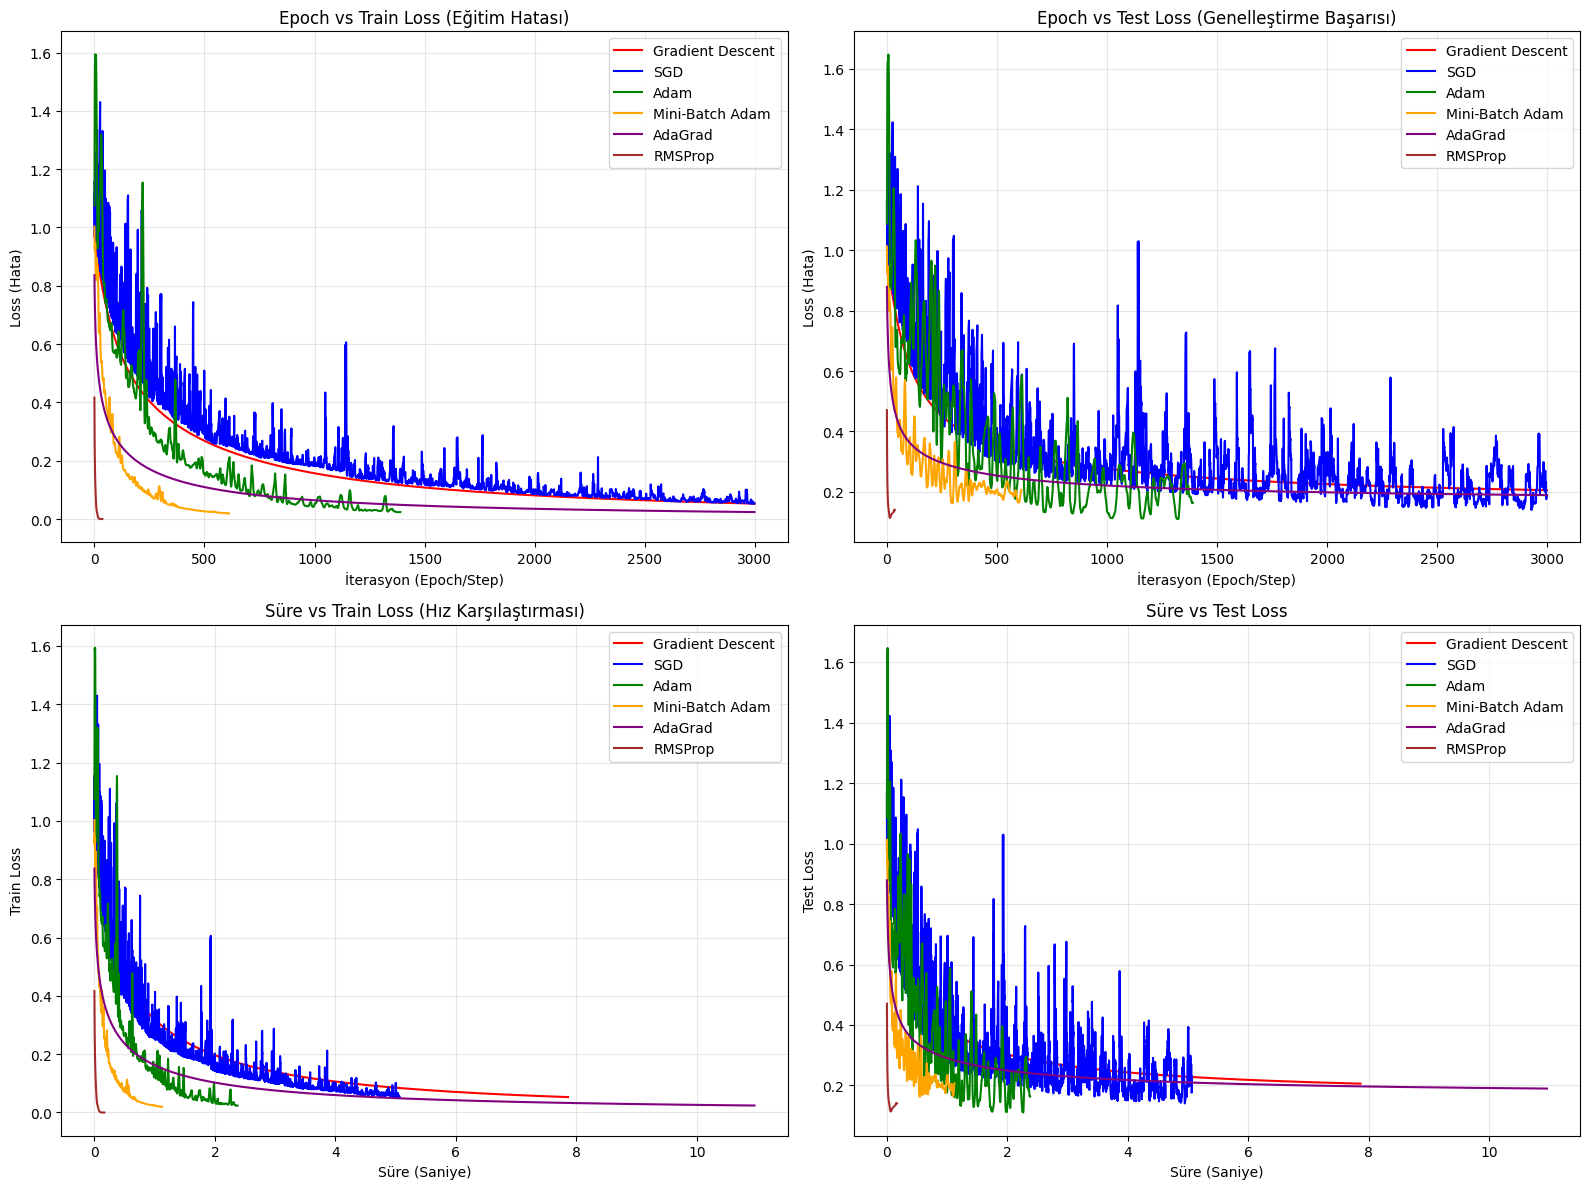

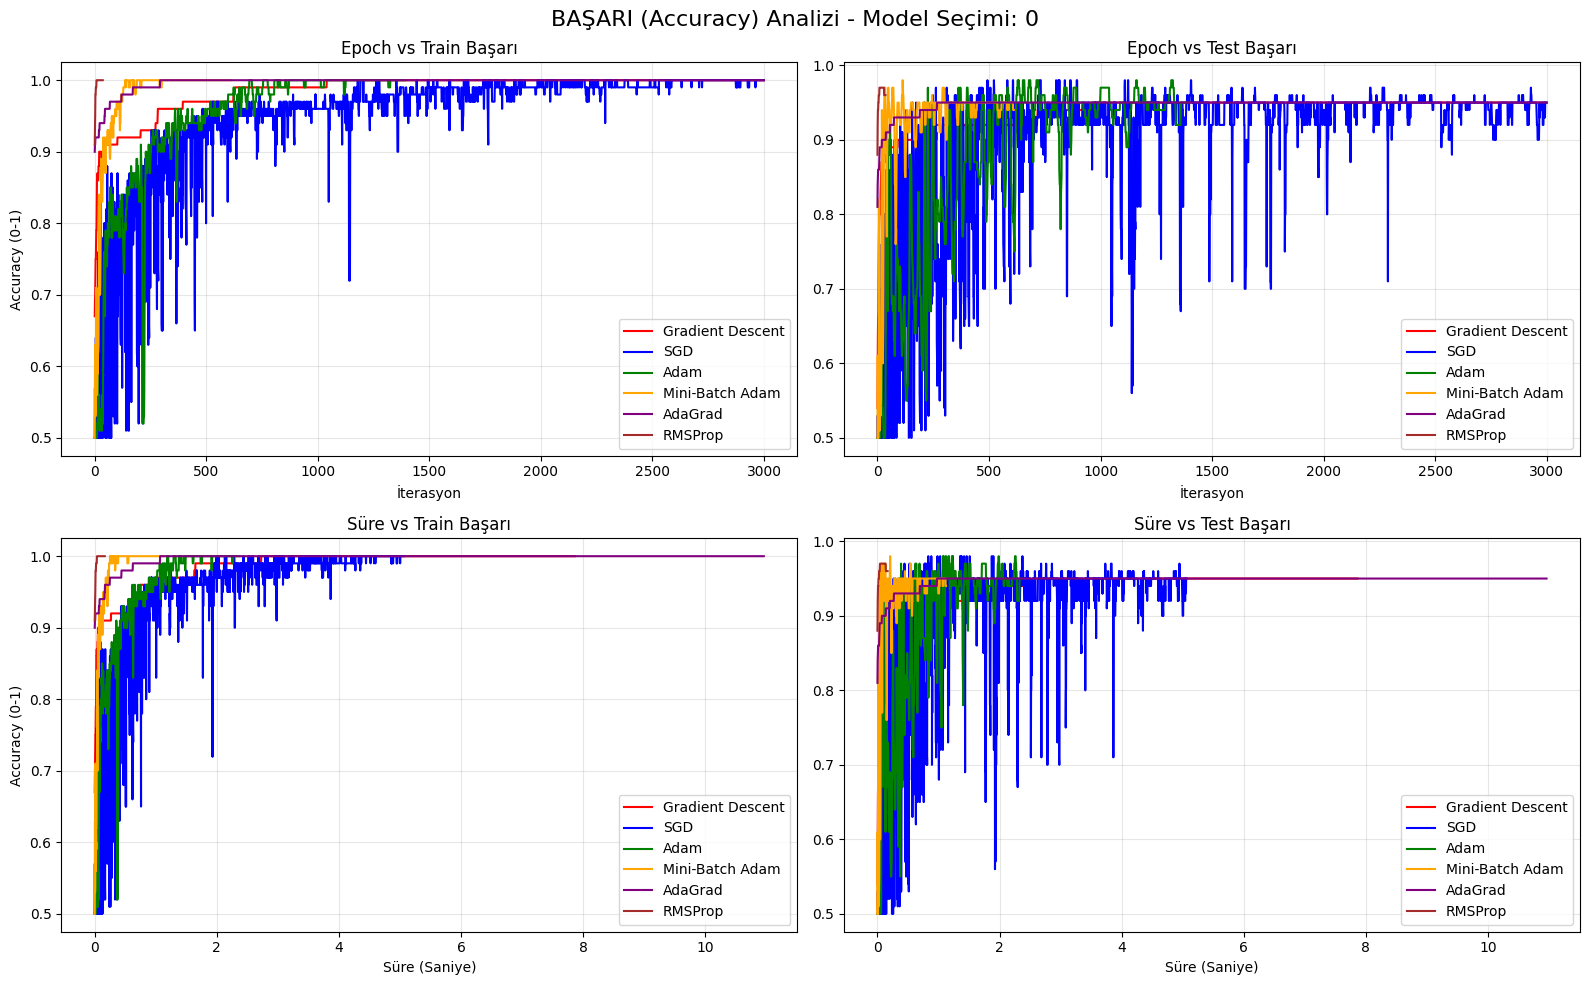

In [58]:

graphics(methods,times,steps,train_results,test_results,0)

Kararlılık testi başlıyor: 5 farklı başlangıç ağırlığı ile test edilecek...
Deneme 1/5 yapılıyor...
Deneme 2/5 yapılıyor...
Deneme 3/5 yapılıyor...
Deneme 4/5 yapılıyor...
Deneme 5/5 yapılıyor...
Grafikler çiziliyor...


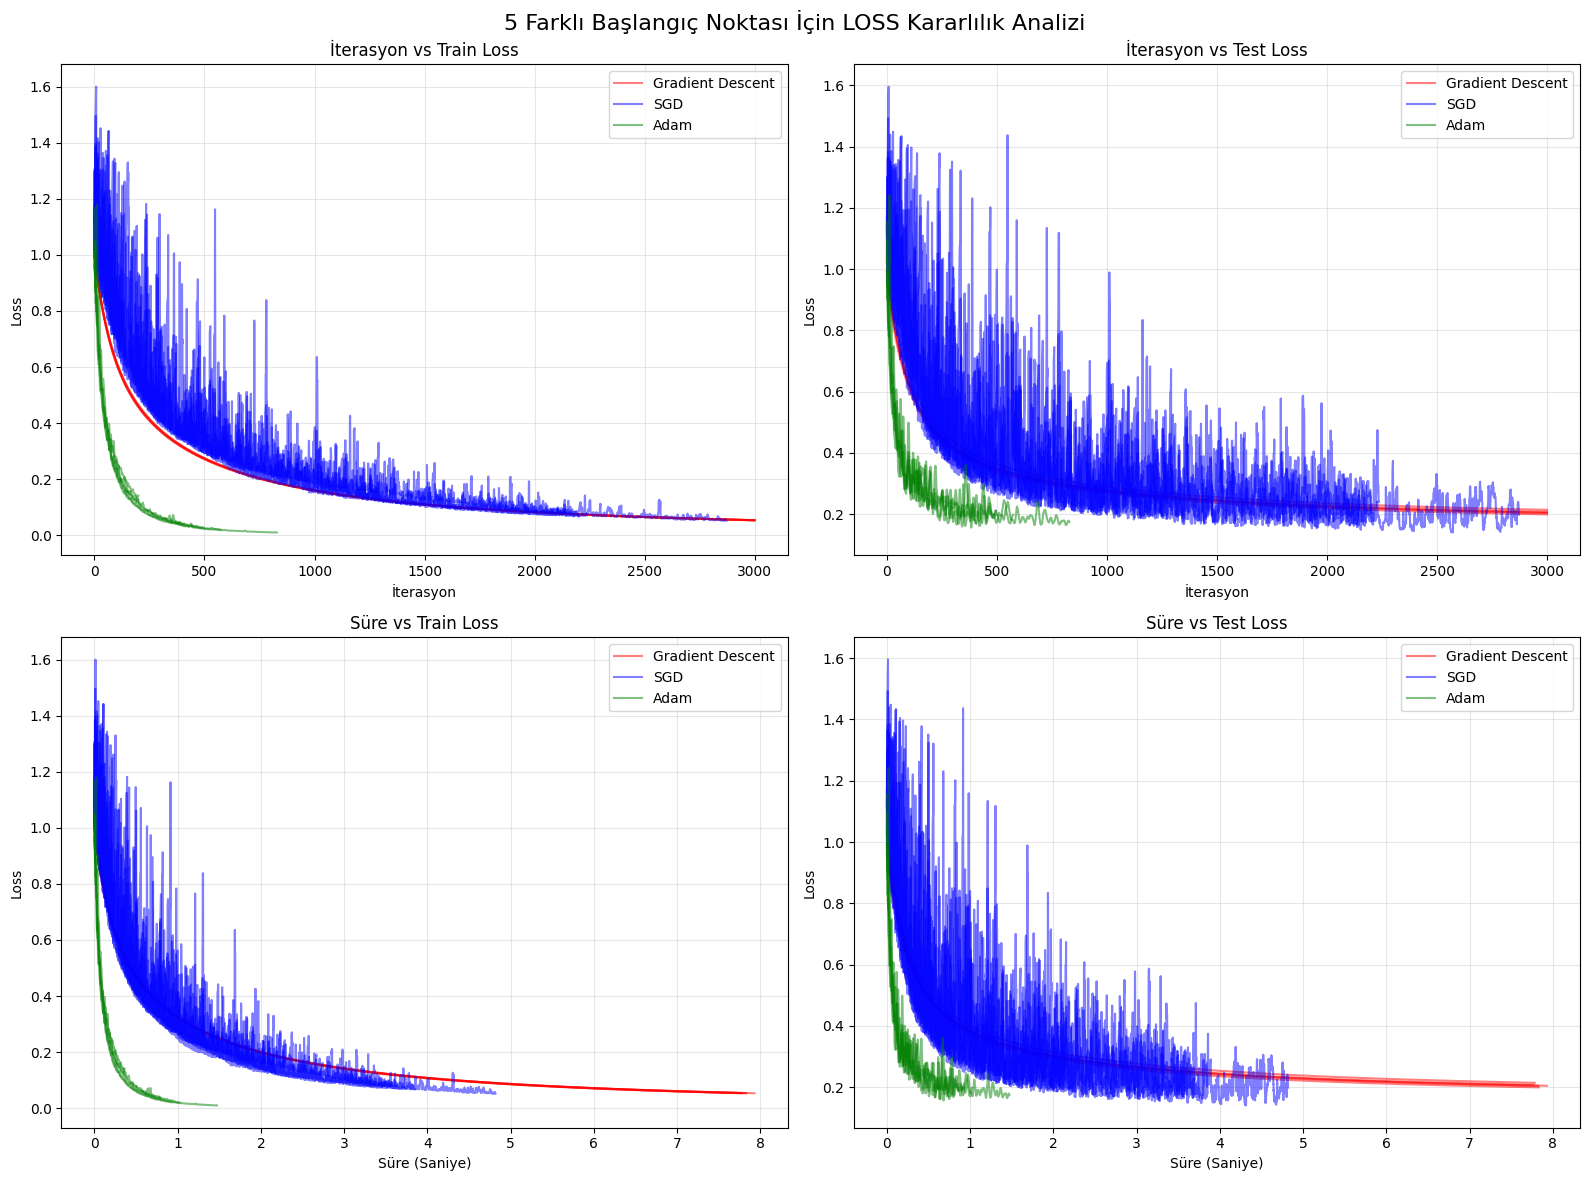

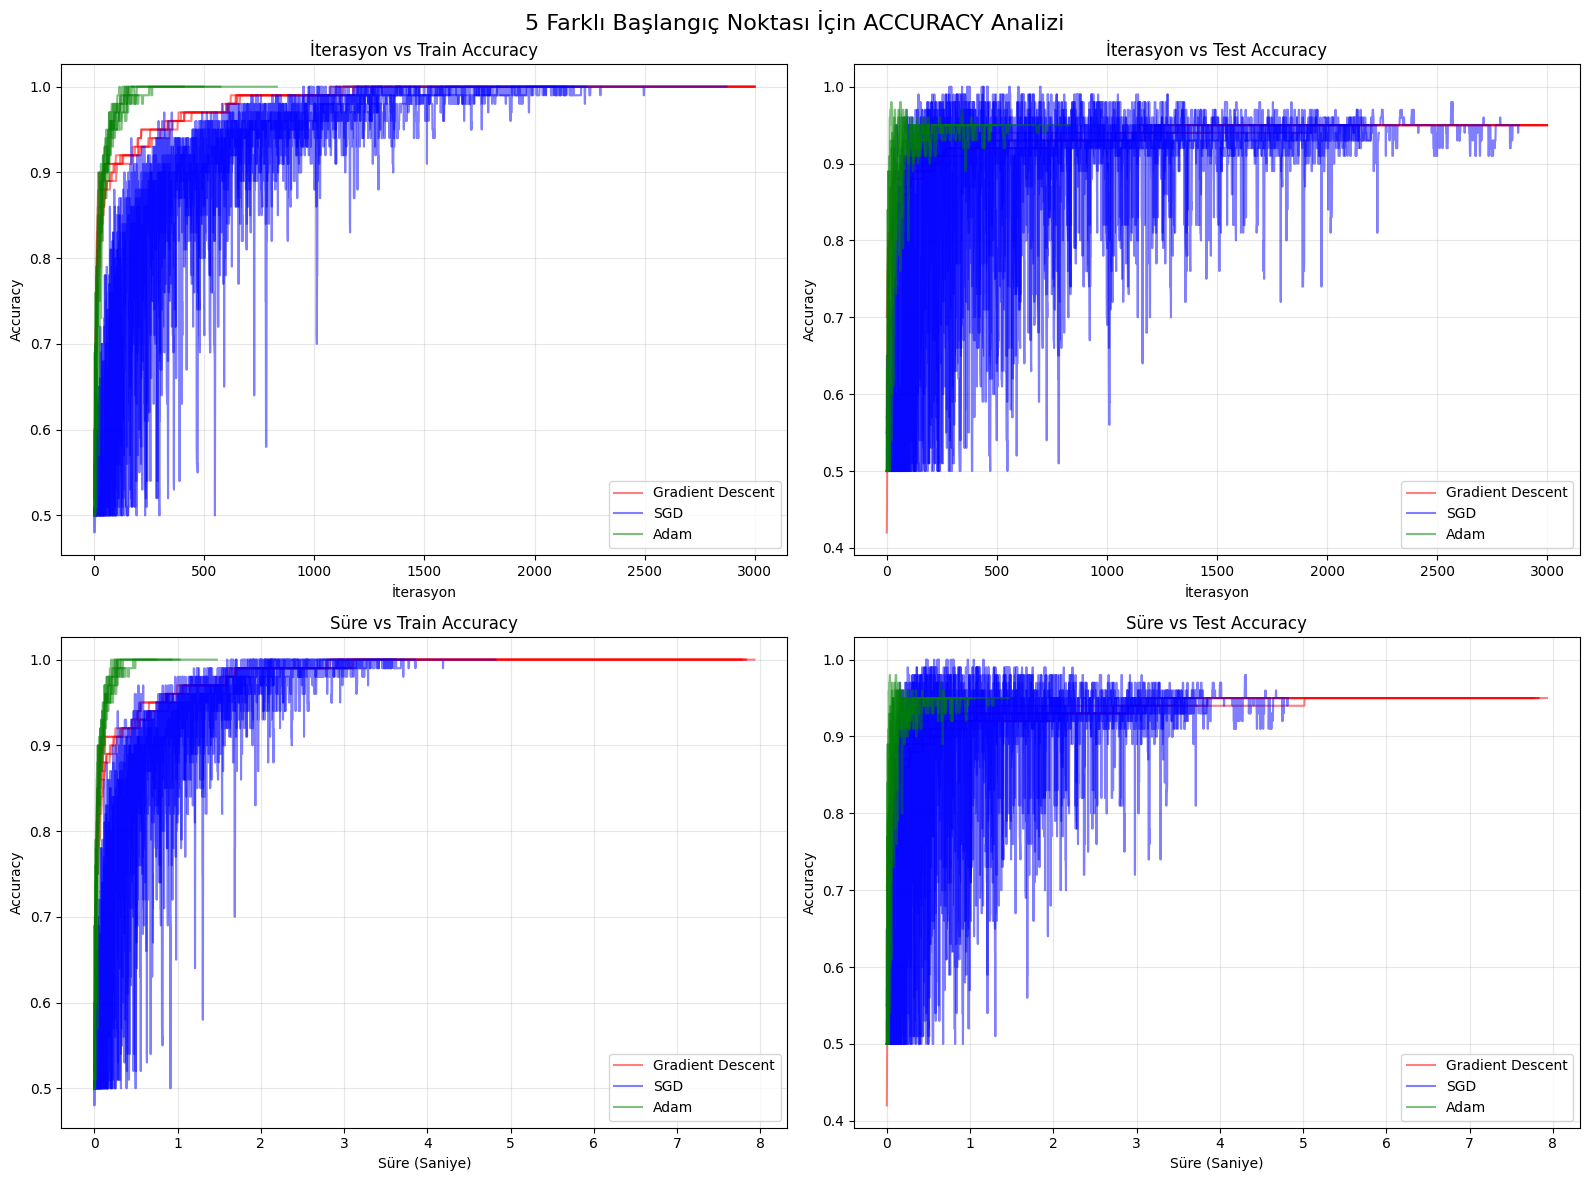

In [59]:
graphics_stability(0)

In [60]:
def t_sne():
    print("T-sne görselleştirmesi")
    algorithms = [
        (gradient_descent, "Gradient Descent"),
        (stochastic_gradient_descent, "SGD"),
        (adam, "Adam"),
        (batched_adam, "Mini-Batch Adam"),
        (adagrad, "AdaGrad"),
        (rmsprop, "RMSPROP")

    ]


    for func, name in algorithms:
        print(f"{name} için veriler hazırlanıyor...")
        
        all_paths = []    # 5 denemenin tüm noktaları burada toplanacak
        lengths = []      # Her denemenin kaç adım sürdüğünü tutacağız
        
        # 5 farklı başlangıç noktası için çalıştır
        for k in range(5):
            w_init = random.uniform(-1, 1)
            # Weights boyutunu sıfırdan oluşturuyoruz ki referans karışmasın
            w_temp = np.zeros((1, 2049)) 
            w_temp.fill(w_init)
            
            # Fonksiyonu çağır (dönen 3. değer w_path)
            _, _, _,_,_,path = func(w_temp, x_train, y_train,x_test,y_test,0)
            
            all_paths.extend(path)
            lengths.append(len(path))

        # Veriyi Numpy array yap
        X_all = np.array(all_paths)
        
        # T-SNE Uygula (Tek seferde tüm 5 yolu 2 boyuta indir)
        # Hız için n_iter=300 yapıldı, standart 1000'dir.
        tsne = TSNE(n_components=2, init='pca', learning_rate='auto', n_iter=300)
        X_embedded = tsne.fit_transform(X_all)

        # Grafiği Çiz
        plt.figure(figsize=(8, 6))
        start_idx = 0
        colors = ['r', 'g', 'b', 'c', 'm']
        
        for k in range(5):
            end_idx = start_idx + lengths[k]
            # O denemeye ait 2 boyutlu koordinatları çek
            traj_2d = X_embedded[start_idx:end_idx]
            
            plt.plot(traj_2d[:, 0], traj_2d[:, 1], marker='.', markersize=2, alpha=0.5, label=f'Run {k+1}', color=colors[k])
            # Başlangıç (Yıldız) ve Bitiş (X)
            plt.plot(traj_2d[0, 0], traj_2d[0, 1], marker='*', markersize=12, color=colors[k], markeredgecolor='k')
            plt.plot(traj_2d[-1, 0], traj_2d[-1, 1], marker='X', markersize=8, color=colors[k], markeredgecolor='k')
            
            start_idx = end_idx

        plt.title(f"{name} - 5 Farklı Başlangıç Yörüngesi (T-SNE 2D)")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.legend()
        plt.grid(True)
        plt.show()

T-sne görselleştirmesi
Gradient Descent için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


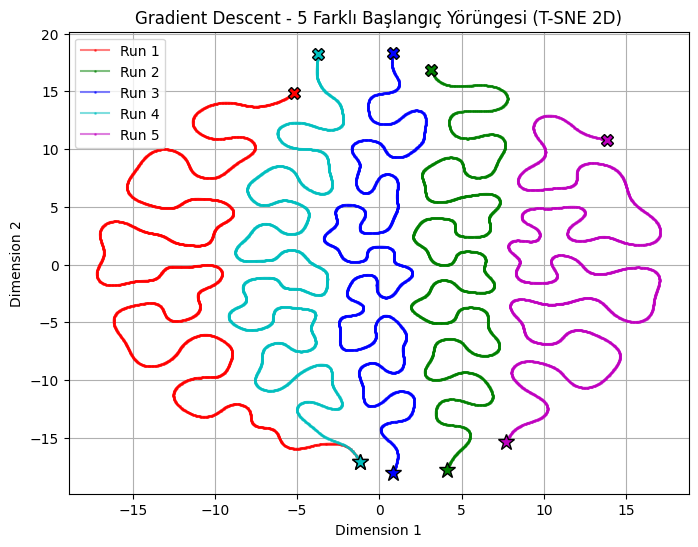

SGD için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


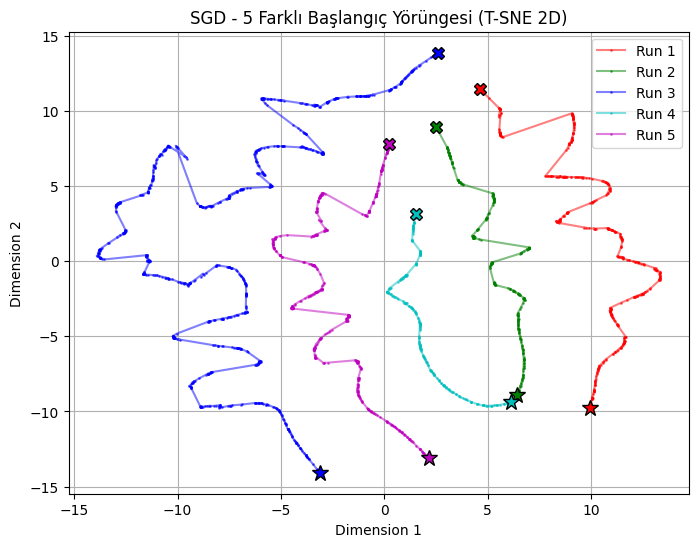

Adam için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


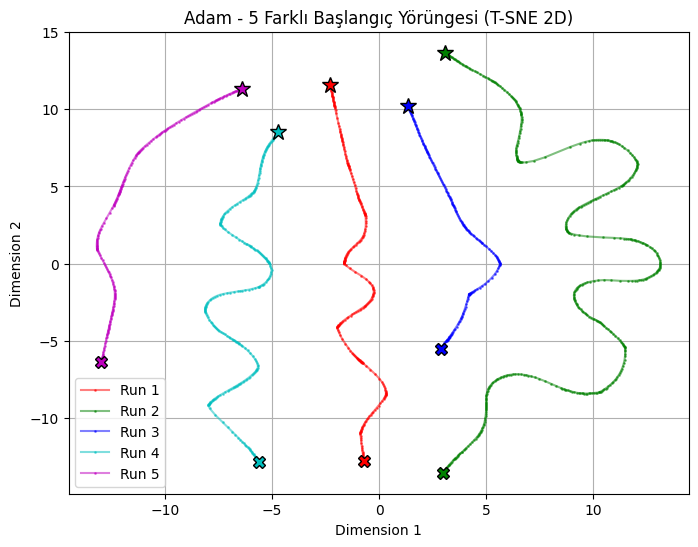

Mini-Batch Adam için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


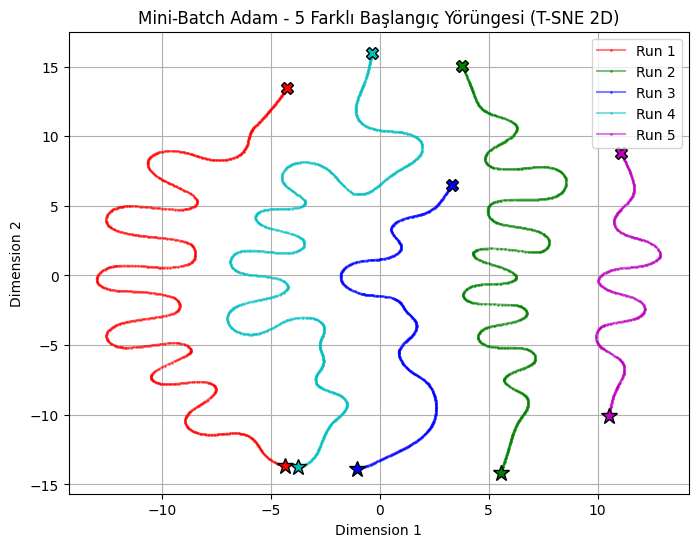

AdaGrad için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


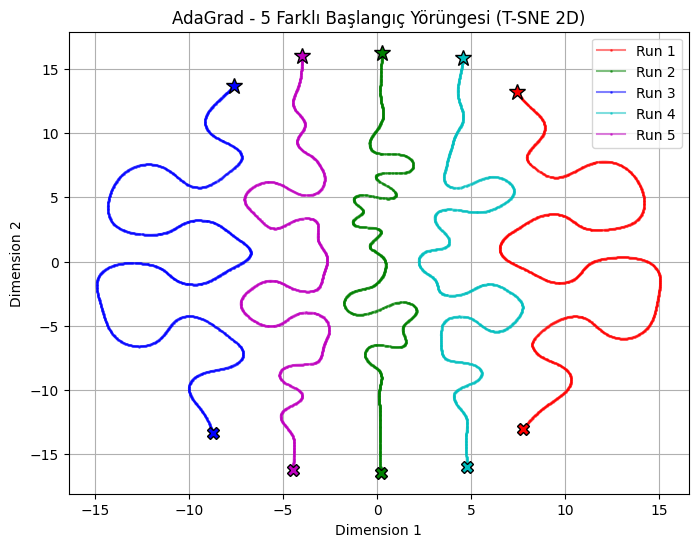

RMSPROP için veriler hazırlanıyor...


c:\Users\fatih\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


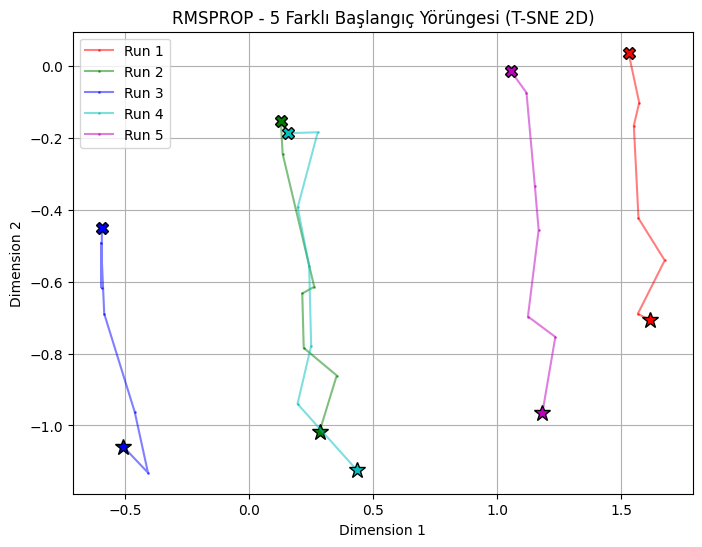

In [61]:
t_sne()

Veri setini arttırmak basariyi nasil etkiler?
eğitim veri setindeki soru sayısını 50 den 250 ye çıkardım

In [62]:
weights,x_train,x_test,y_train,y_test = import_datasets(1)
methods,times,steps,train_results,test_results = five_result(0)


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.20243448], Accuracy: 0.95
SGD Test MSE: [0.28855356], Accuracy: 0.95
Adam Test MSE: [0.13464519], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.12684367], Accuracy: 0.95
AdaGradTest MSE: [0.13950481], Accuracy: 0.95
RMSPROP Test MSE: [0.11628855], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.20243448], Accuracy: 0.95
SGD Test MSE: [0.20087518], Accuracy: 0.95
Adam Test MSE: [0.21860013], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.09955636], Accuracy: 0.95
AdaGradTest MSE: [0.13950481], Accuracy: 0.95
RMSPROP Test MSE: [0.11628855], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.20243448], Accuracy: 0.95
SGD Test MSE: [0.28617845], Accuracy: 0.95
Adam Test MSE: [0.19155413], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.11398875], Accuracy: 0.95
AdaGradTest MSE: [0.13950481], Accuracy: 0.95
RMSPROP Test MSE: [0.11628855], Accuracy: 0.96

Rastgele küçük weightler ile deneme: 4

GD Te

Algoritmalar çalıştırılıyor ve veriler toplanıyor...
Gradient Descent koşuluyor...
SGD koşuluyor...
Adam koşuluyor...
Mini-Batch Adam koşuluyor...
AdaGrad koşuluyor...
RMSProp koşuluyor...
Grafikler çiziliyor...


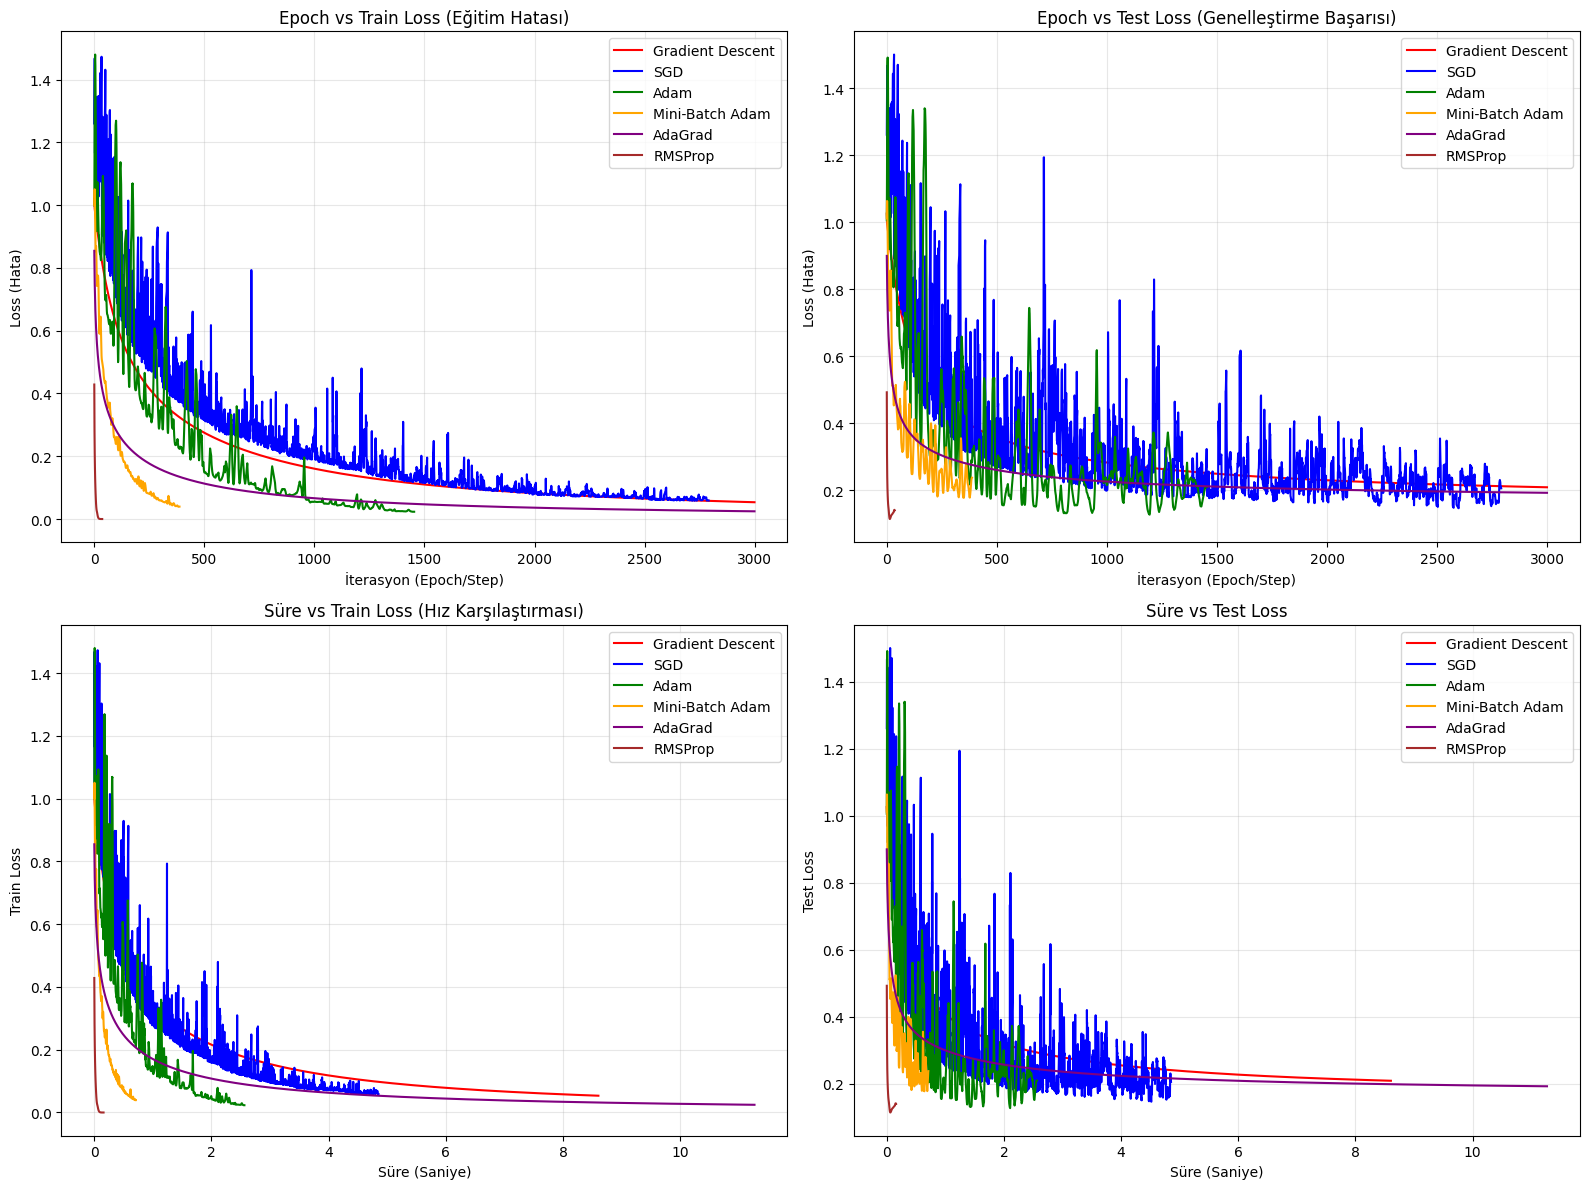

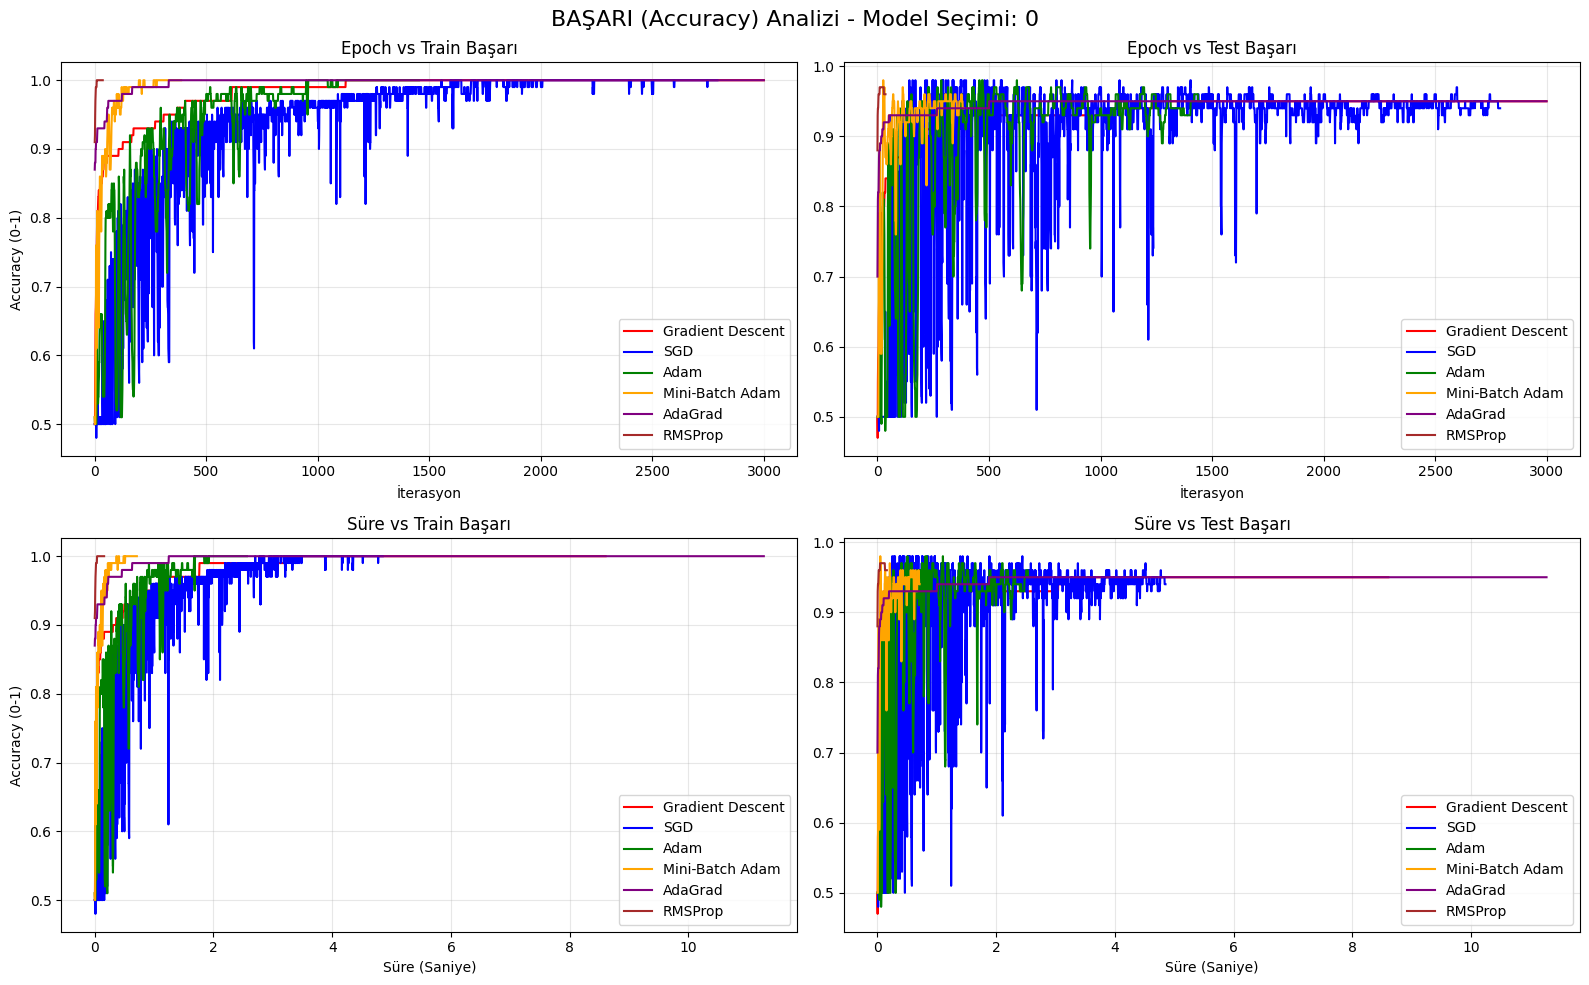

In [63]:
graphics(methods,times,steps,train_results,test_results,0)
#t_sne()

bge-m3 modeli ile 250 örneği vektörleştirip test etme


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.16873069], Accuracy: 0.99
SGD Test MSE: [0.19757123], Accuracy: 0.99
Adam Test MSE: [0.19610263], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.15676175], Accuracy: 0.99
AdaGradTest MSE: [0.13936991], Accuracy: 0.97
RMSPROP Test MSE: [0.20516874], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.16873069], Accuracy: 0.99
SGD Test MSE: [0.28947842], Accuracy: 0.99
Adam Test MSE: [0.17305852], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.14283684], Accuracy: 0.99
AdaGradTest MSE: [0.13936991], Accuracy: 0.97
RMSPROP Test MSE: [0.20516874], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.16873069], Accuracy: 0.99
SGD Test MSE: [0.18463117], Accuracy: 0.99
Adam Test MSE: [0.27948318], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.13182662], Accuracy: 0.99
AdaGradTest MSE: [0.13936991], Accuracy: 0.97
RMSPROP Test MSE: [0.20516874], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 4

GD Te

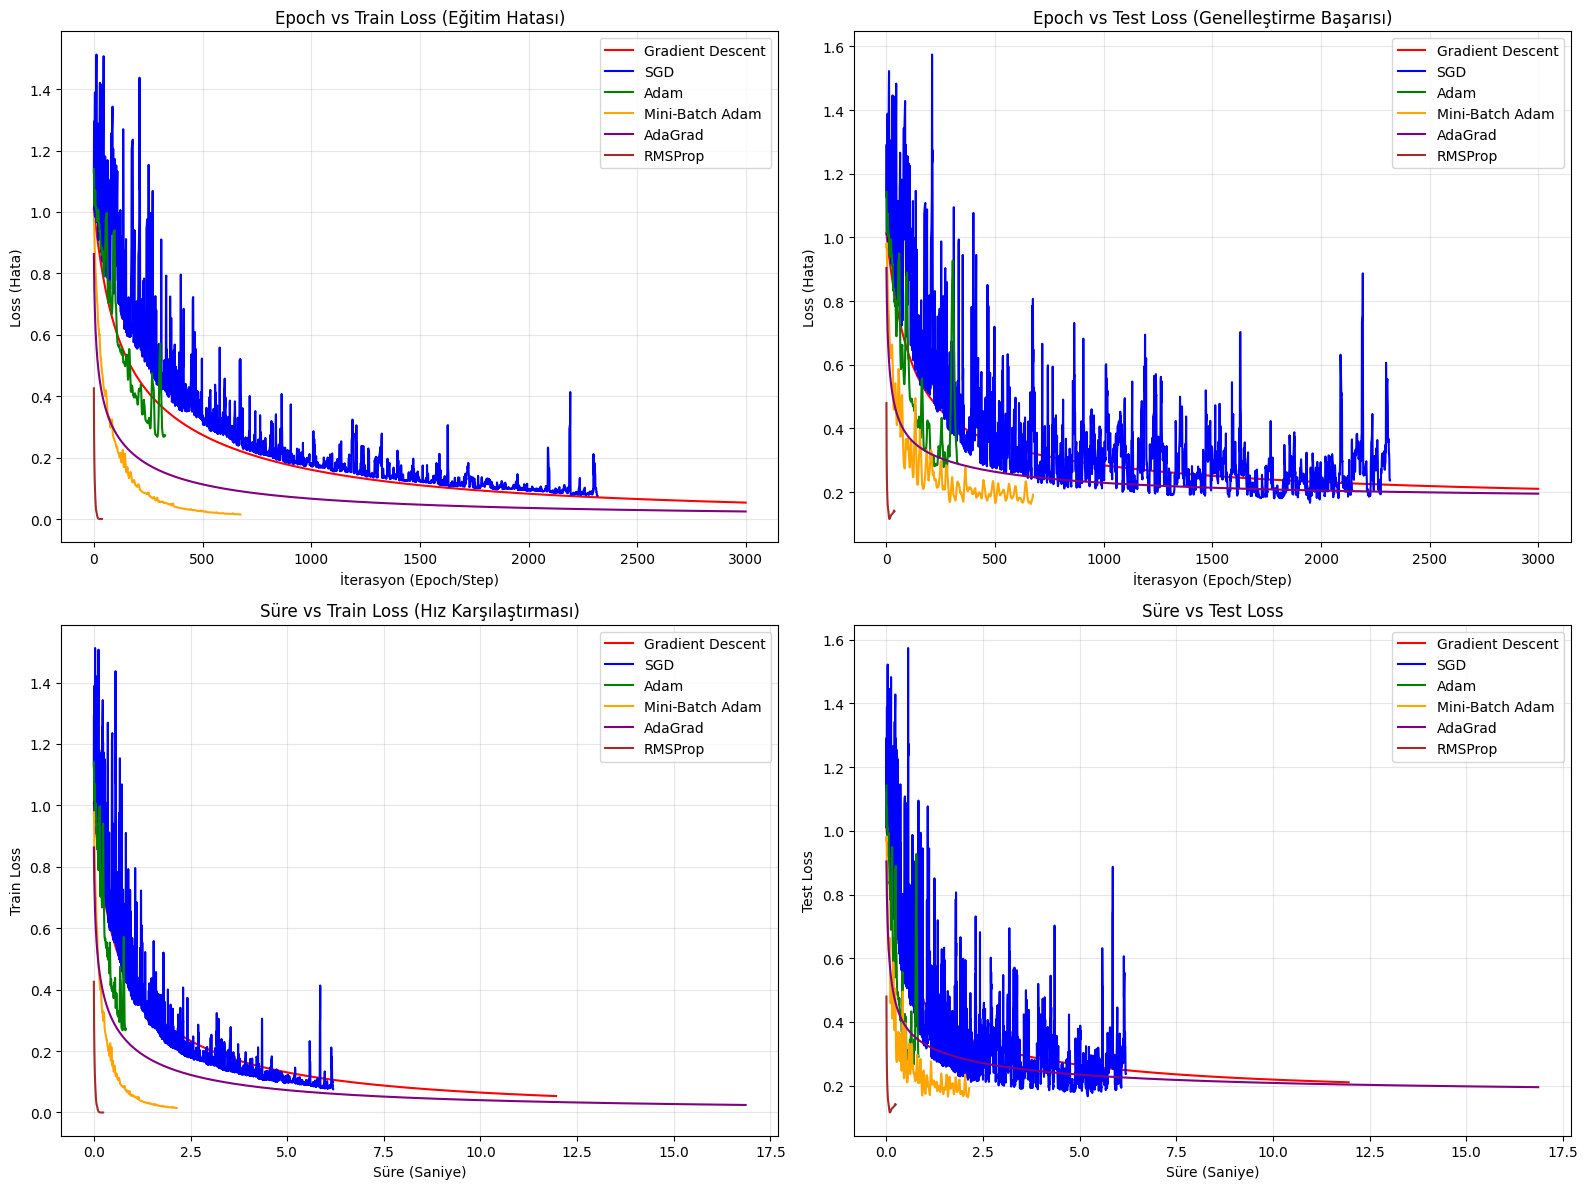

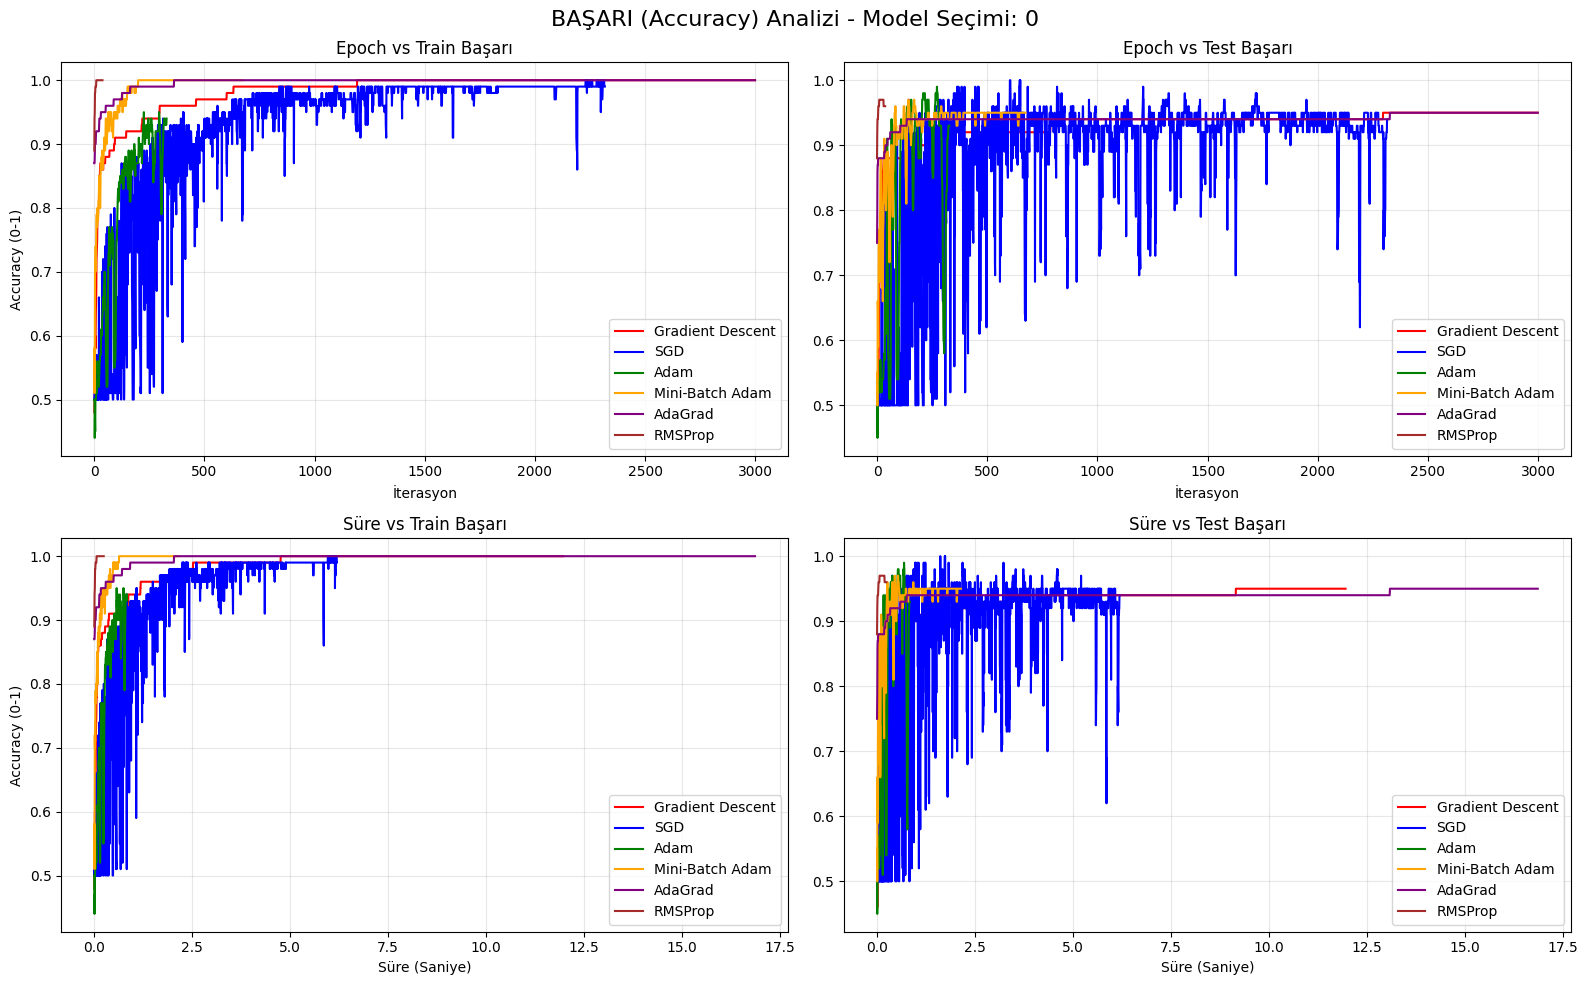

In [64]:
weights,x_train,x_test,y_train,y_test = import_datasets(4)
methods,times,steps,train_results,test_results = five_result(0)
graphics(methods,times,steps,train_results,test_results,0)

Multilingual E5 Large Model ile test edilmesi


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.16839887], Accuracy: 0.99
SGD Test MSE: [0.21902677], Accuracy: 0.99
Adam Test MSE: [0.15213577], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.15149874], Accuracy: 0.99
AdaGradTest MSE: [0.13911998], Accuracy: 0.97
RMSPROP Test MSE: [0.20557217], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.16839887], Accuracy: 0.99
SGD Test MSE: [0.24167482], Accuracy: 0.99
Adam Test MSE: [0.17213234], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.15696994], Accuracy: 0.99
AdaGradTest MSE: [0.13911998], Accuracy: 0.97
RMSPROP Test MSE: [0.20557217], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.16839887], Accuracy: 0.99
SGD Test MSE: [0.18000354], Accuracy: 0.99
Adam Test MSE: [0.15295799], Accuracy: 0.99
Mini-Batch Adam Test MSE: [0.1285615], Accuracy: 0.99
AdaGradTest MSE: [0.13911998], Accuracy: 0.97
RMSPROP Test MSE: [0.20557217], Accuracy: 0.93

Rastgele küçük weightler ile deneme: 4

GD Tes

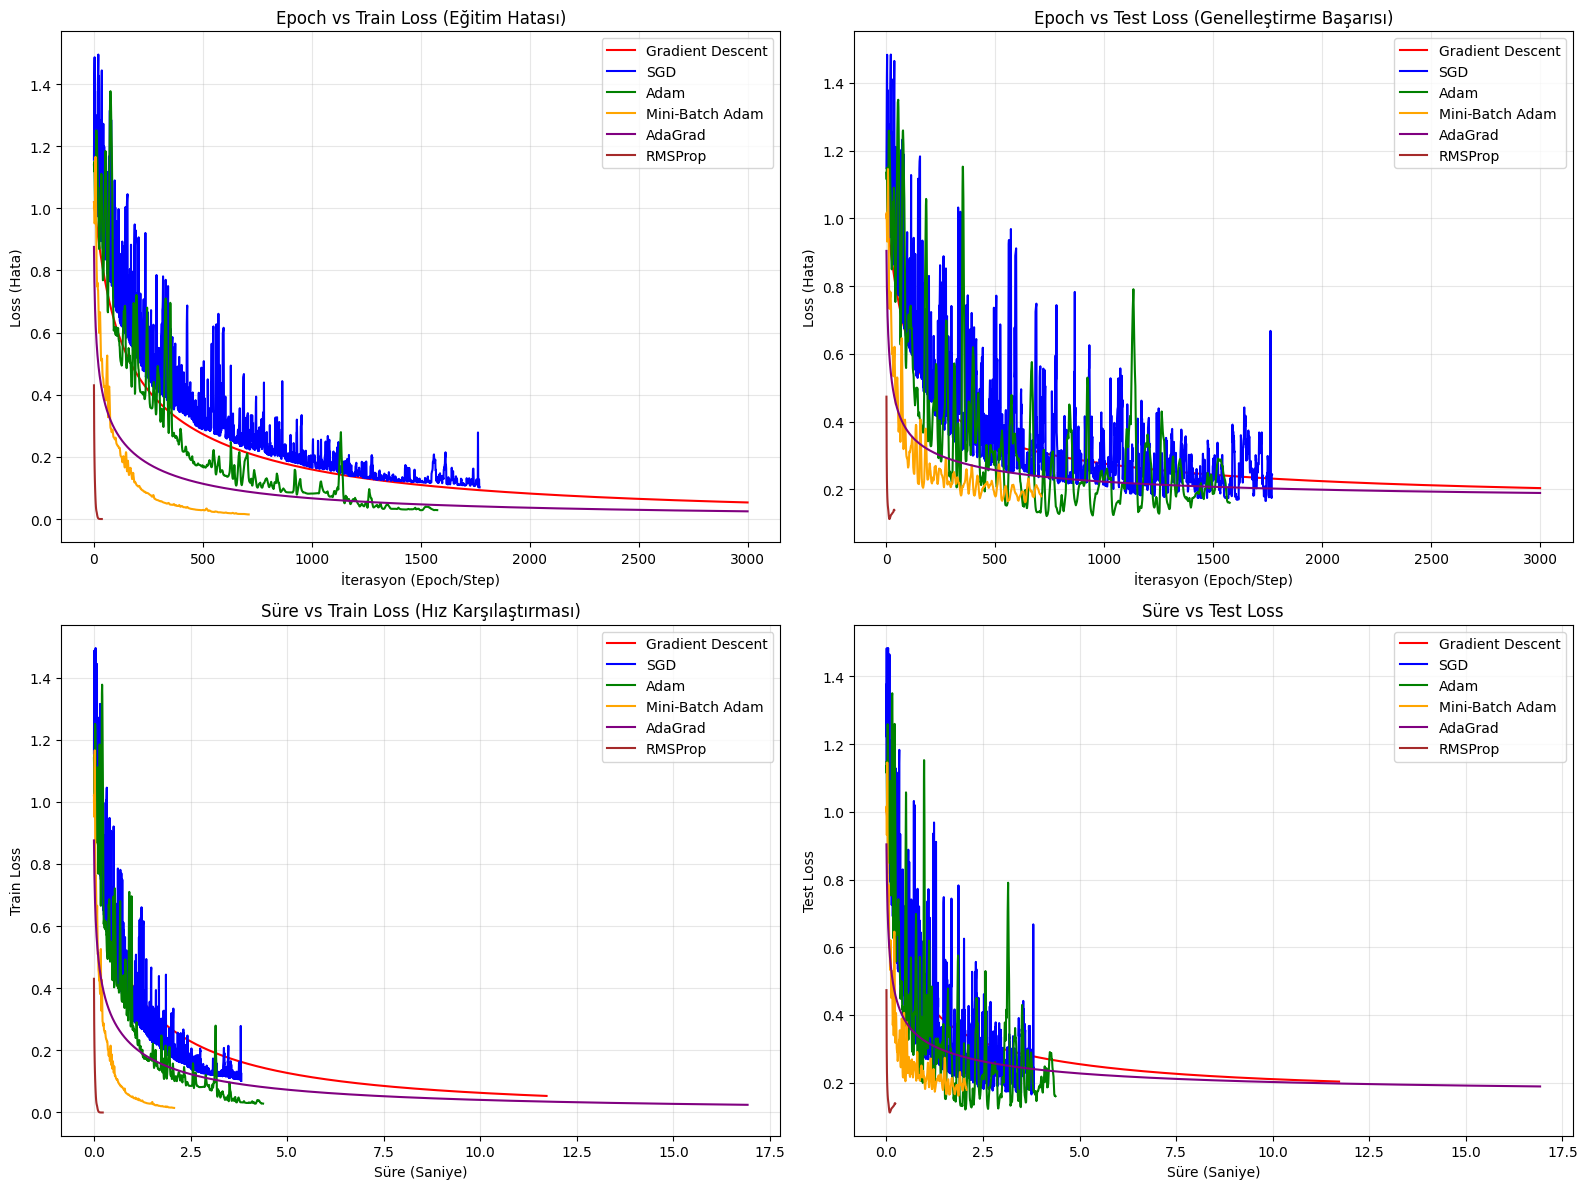

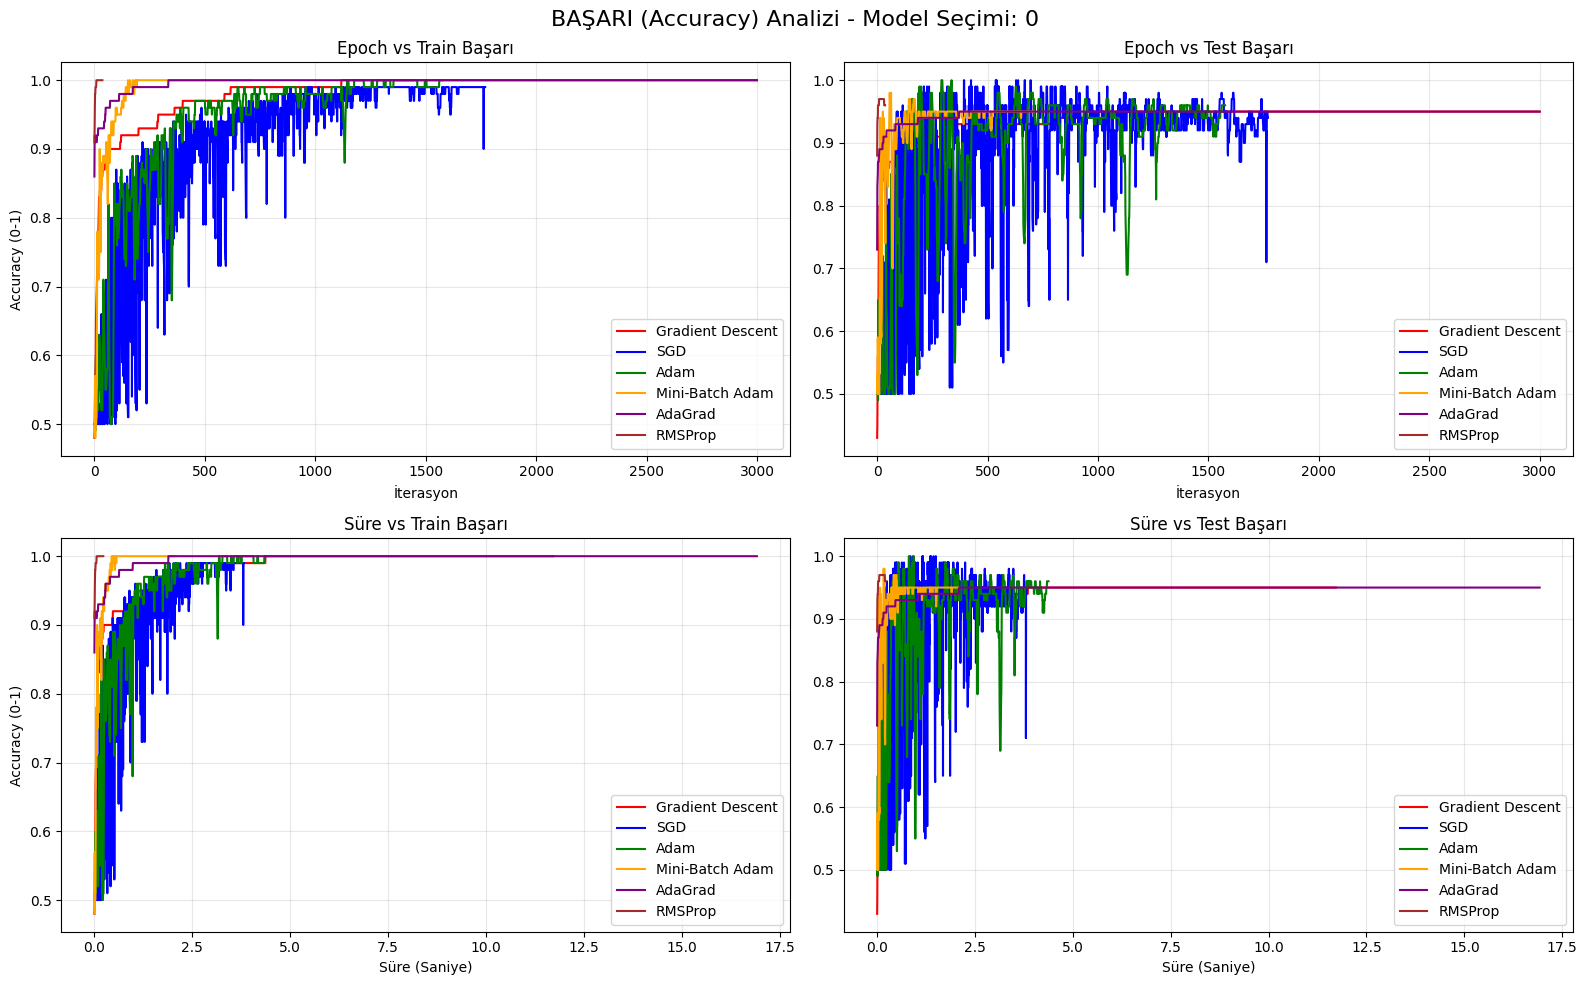

In [65]:
weights,x_train,x_test,y_train,y_test = import_datasets(4)
methods,times,steps,train_results,test_results = five_result(0)

graphics(methods,times,steps,train_results,test_results,0)

+1 boyut ekleyip bunu soru ile cevap vektörlerinin skaler çarpımı yaptım. Büyük veri setinde denedim


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.01977872], Accuracy: 1.0
SGD Test MSE: [0.04385753], Accuracy: 1.0
Adam Test MSE: [0.15273926], Accuracy: 1.0
Mini-Batch Adam Test MSE: [0.08087122], Accuracy: 1.0
AdaGradTest MSE: [0.08915316], Accuracy: 0.98
RMSPROP Test MSE: [0.03846456], Accuracy: 0.98

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.01977872], Accuracy: 1.0
SGD Test MSE: [0.05269949], Accuracy: 1.0
Adam Test MSE: [0.11208964], Accuracy: 1.0
Mini-Batch Adam Test MSE: [0.06979032], Accuracy: 1.0
AdaGradTest MSE: [0.08915316], Accuracy: 0.98
RMSPROP Test MSE: [0.03846456], Accuracy: 0.98

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.01977872], Accuracy: 1.0
SGD Test MSE: [0.04570317], Accuracy: 1.0
Adam Test MSE: [0.59295096], Accuracy: 1.0
Mini-Batch Adam Test MSE: [0.08898819], Accuracy: 1.0
AdaGradTest MSE: [0.08915316], Accuracy: 0.98
RMSPROP Test MSE: [0.03846456], Accuracy: 0.98

Rastgele küçük weightler ile deneme: 4

GD Test MSE: [0.0

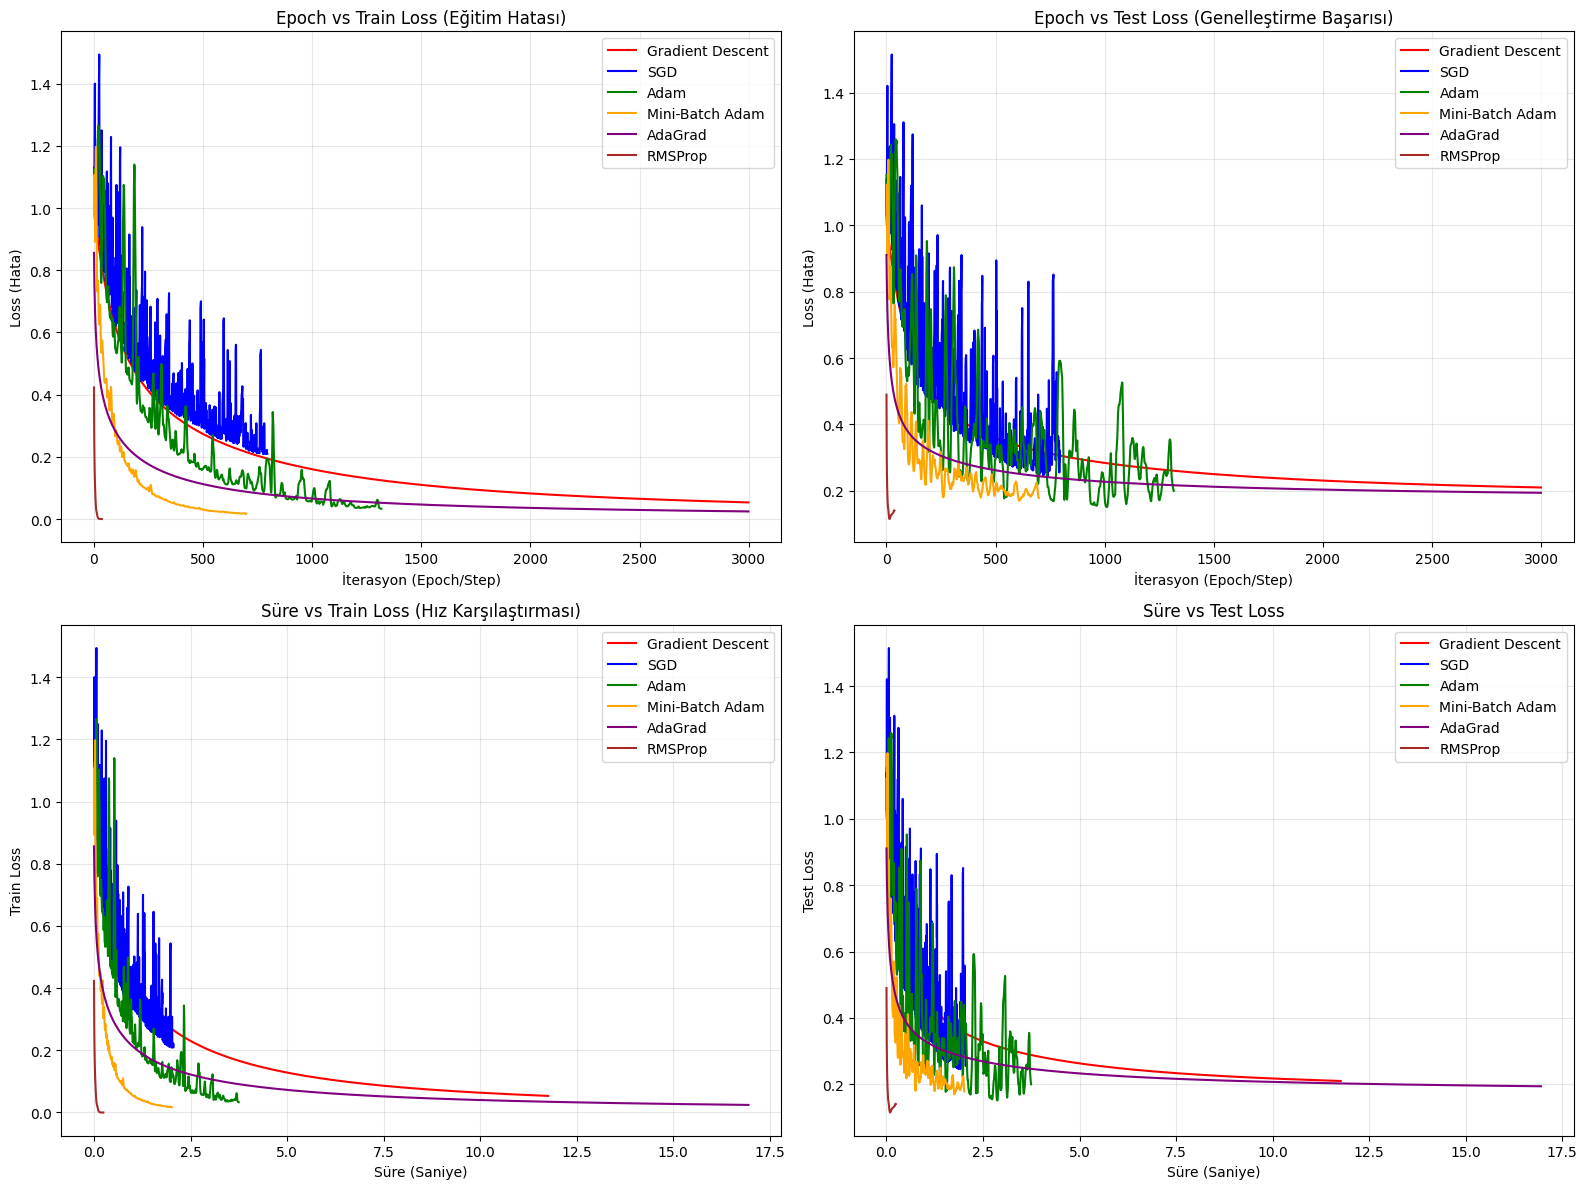

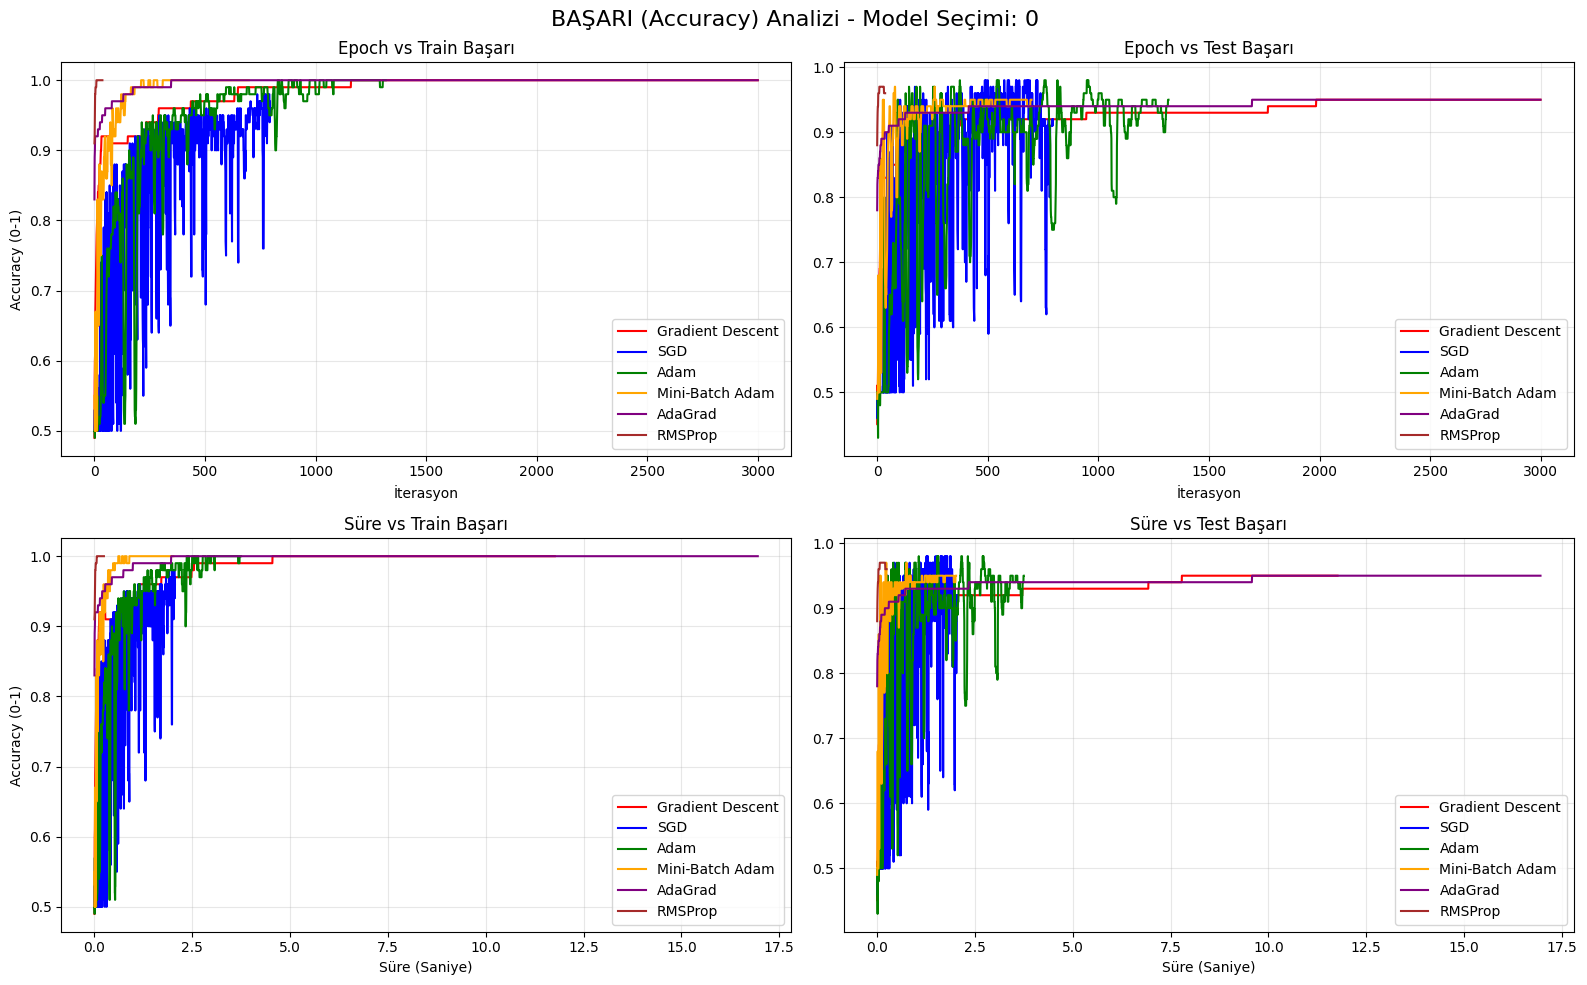

In [66]:
weights,x_train,x_test,y_train,y_test = import_datasets(3)
methods,times,steps,train_results,test_results =five_result(0)

graphics(methods,times,steps,train_results,test_results,0)

In [67]:
#graphics(methods,times,steps,train_results,test_results)

sigmoid function ile

In [71]:
weights,x_train,x_test,y_train,y_test = import_datasets(2)
methods,times,steps,train_results,test_results = five_result(1)

#raphics(methods,times,steps,train_results,test_results,1)


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.34585801], Accuracy: 0.92
SGD Test MSE: [0.53676929], Accuracy: 0.92
Adam Test MSE: [0.47908754], Accuracy: 0.92
Mini-Batch Adam Test MSE: [0.48721635], Accuracy: 0.92
AdaGradTest MSE: [0.49508596], Accuracy: 0.69
RMSPROP Test MSE: [0.46624486], Accuracy: 0.75

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.34585801], Accuracy: 0.92
SGD Test MSE: [0.62156329], Accuracy: 0.92
Adam Test MSE: [0.52364864], Accuracy: 0.92
Mini-Batch Adam Test MSE: [0.48441659], Accuracy: 0.92
AdaGradTest MSE: [0.49508596], Accuracy: 0.69
RMSPROP Test MSE: [0.46624486], Accuracy: 0.75

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.34585801], Accuracy: 0.92
SGD Test MSE: [0.55695694], Accuracy: 0.92
Adam Test MSE: [0.49644017], Accuracy: 0.92
Mini-Batch Adam Test MSE: [0.49188029], Accuracy: 0.92
AdaGradTest MSE: [0.49508596], Accuracy: 0.69
RMSPROP Test MSE: [0.46624486], Accuracy: 0.75

Rastgele küçük weightler ile deneme: 4

GD Te

RELU

In [72]:
weights,x_train,x_test,y_train,y_test = import_datasets(2)
methods,times,steps,train_results,test_results = five_result(2)

#raphics(methods,times,steps,train_results,test_results,2)


Rastgele küçük weightler ile deneme: 1

GD Test MSE: [0.06658977], Accuracy: 0.95
SGD Test MSE: [0.05656675], Accuracy: 0.95
Adam Test MSE: [0.70606654], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.08124772], Accuracy: 0.95
AdaGradTest MSE: [0.43954188], Accuracy: 0.9
RMSPROP Test MSE: [3.81865335], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 2

GD Test MSE: [0.06658977], Accuracy: 0.95
SGD Test MSE: [0.0778123], Accuracy: 0.95
Adam Test MSE: [0.52727735], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.43284213], Accuracy: 0.95
AdaGradTest MSE: [0.43954188], Accuracy: 0.9
RMSPROP Test MSE: [3.81865335], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 3

GD Test MSE: [0.06658977], Accuracy: 0.95
SGD Test MSE: [0.060782], Accuracy: 0.95
Adam Test MSE: [0.54199138], Accuracy: 0.95
Mini-Batch Adam Test MSE: [0.16700017], Accuracy: 0.95
AdaGradTest MSE: [0.43954188], Accuracy: 0.9
RMSPROP Test MSE: [3.81865335], Accuracy: 0.81

Rastgele küçük weightler ile deneme: 4

GD Test MSE

2 KATMANLI MLP

In [70]:
weights,x_train,x_test,y_train,y_test = import_datasets(6)

gd_weights,_,_,_,_,_ = gradient_descent(weights,x_train,y_train,x_test,y_test,3)
print(f"Gradient Descent MSE: {cost(gd_weights,x_test,y_test,3)}")


Gradient Descent MSE: [0.1686702]
